## Importing Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import linprog
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from joblib import dump, load
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import pickle as pkl
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix,multilabel_confusion_matrix,recall_score
import pickle as pkl

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Release 14 of phase 4 of SDSS extracted from SDSS site using SQL query. Images of the spectrum of the objects were scrapped from SDSS website using selenium library.

In [ ]:
d = pd.read_csv('/content/DR14_SDSS_new.csv',skiprows=1)

In [ ]:
d.head() 

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648705131905049,224.367913,0.492218,18.30940,17.13075,16.63043,16.43888,16.33171,752,301,5,540,3731360742641868800,STAR,0.000256,3314,54970,467
1,1237648705131905146,224.469246,0.532670,18.22791,17.03074,16.47815,16.24079,16.09382,752,301,5,540,3731361567275589632,STAR,0.000687,3314,54970,470
2,1237648705131905248,224.379514,0.437444,18.55948,17.31544,16.71859,16.32946,16.09309,752,301,5,540,348053737761171456,GALAXY,0.083711,309,51994,548
3,1237648705131970600,224.502897,0.497601,18.55733,17.24357,16.62276,16.34301,16.20834,752,301,5,541,3731361017519775744,STAR,-0.000022,3314,54970,468
4,1237648705131970604,224.506416,0.568373,17.54774,16.37762,15.95853,15.80821,15.75121,752,301,5,541,3731361842153496576,STAR,-0.000084,3314,54970,471


In [ ]:
d.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      30000 non-null  int64  
 1   ra         30000 non-null  float64
 2   dec        30000 non-null  float64
 3   u          30000 non-null  float64
 4   g          30000 non-null  float64
 5   r          30000 non-null  float64
 6   i          30000 non-null  float64
 7   z          30000 non-null  float64
 8   run        30000 non-null  int64  
 9   rerun      30000 non-null  int64  
 10  camcol     30000 non-null  int64  
 11  field      30000 non-null  int64  
 12  specobjid  30000 non-null  uint64 
 13  class      30000 non-null  object 
 14  redshift   30000 non-null  float64
 15  plate      30000 non-null  int64  
 16  mjd        30000 non-null  int64  
 17  fiberid    30000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 4.1+ MB


In [ ]:
d['class'].value_counts() ## Count for each class

GALAXY    14000
STAR      13227
QSO        2773
Name: class, dtype: int64

In [ ]:
print("There is {}% of Quasar points".format(d['class'].value_counts()[2] / d.shape[0] * 100 ))

There is 9.243333333333334% of Quasar points


In [ ]:
!mkdir 'img'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
get_ipython().system_raw("unrar x /content/drive/MyDrive/Ig1.rar /content/img")

In [ ]:
#read the all file path in the img folder given 
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
from tqdm import tqdm
import os
def readData(Data):
  all_files=[]
  for img in tqdm(os.listdir(Data)):
    all_files.append("/content/img/"+img)
  return all_files
all_files=readData("/content/img")

100%|██████████| 19960/19960 [00:00<00:00, 2313427.32it/s]


In [ ]:
len(all_files)

19960

In [ ]:
res=[]
for j in all_files:
  try:
    res.append((int(''.join(filter(lambda i: i.isdigit(), j))),j)) 
  except:
    pass

In [ ]:
res.sort(key=lambda x:x[0]) ## sorting the paths by indices

In [ ]:
il = [res[i][0] for i in range(len(res))]
data = d.iloc[il] ## getting the data at those indices

In [ ]:
paths = [res[i][1] for i in range(len(res))] ## getting the paths

In [ ]:
data['img_path'] = paths ## adding path of images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## EDA

## Uivariate Analysis

In [ ]:
data['class'].value_counts()

STAR      9140
GALAXY    9109
QSO       1710
Name: class, dtype: int64

Class=2, n=9140 (45.794%)
Class=0, n=9109 (45.639%)
Class=1, n=1710 (8.568%)


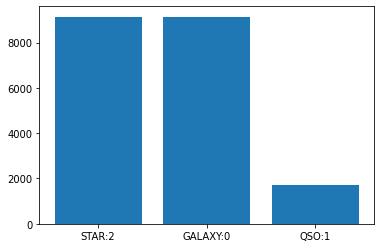

In [ ]:
# Bar plot to understand class imbalance
# Bar plot shows the number of data points of each class 
# This shows high class imbalance 

y = LabelEncoder().fit_transform(data['class'])
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(['STAR:2',"GALAXY:0","QSO:1"], counter.values())
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated

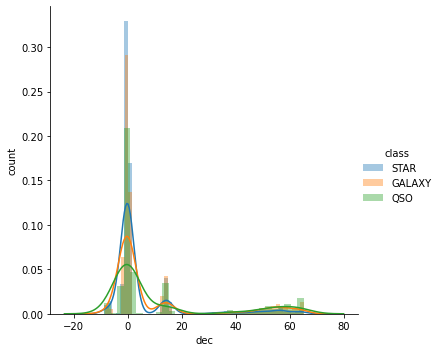

In [ ]:
## The plot below for dec shows it is basically within the range of -15 - 20 and 40-65 for all classes.
## The plot below for ra shows it is basically within the range of 0 - 50 and 100-250 for all classes.
## The bar plot and the pdf is overlapping for all the three classes and thus we cannot actually 
## separate these points on the basis of coordinates. 

sns.FacetGrid(data, hue="class", size=5).map(sns.distplot, "dec").add_legend();
plt.ylabel('count')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated

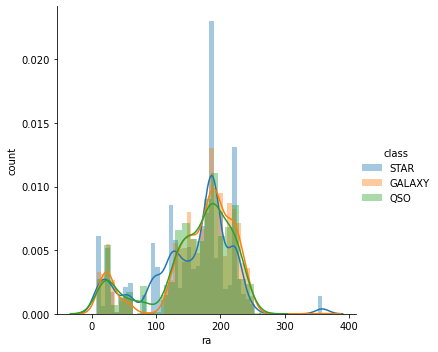

In [ ]:
sns.FacetGrid(data, hue="class", size=5).map(sns.distplot, "ra").add_legend();
plt.ylabel('count')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated

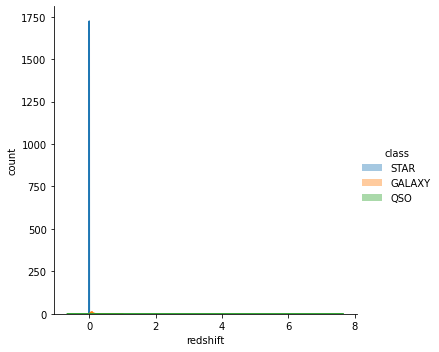

In [ ]:
## The plot below for redsfift shows it is basically around 0 or very small for non quasar point.  
## and very high and diverse and within the range of -1 - 8 for quasar point
## This shows redshift is a very important feature and can be used to
## separate the points of different class. 

sns.FacetGrid(data, hue="class", size=5).map(sns.distplot, "redshift").add_legend();
plt.ylabel('count')
plt.show()

## Multivariate Analysis

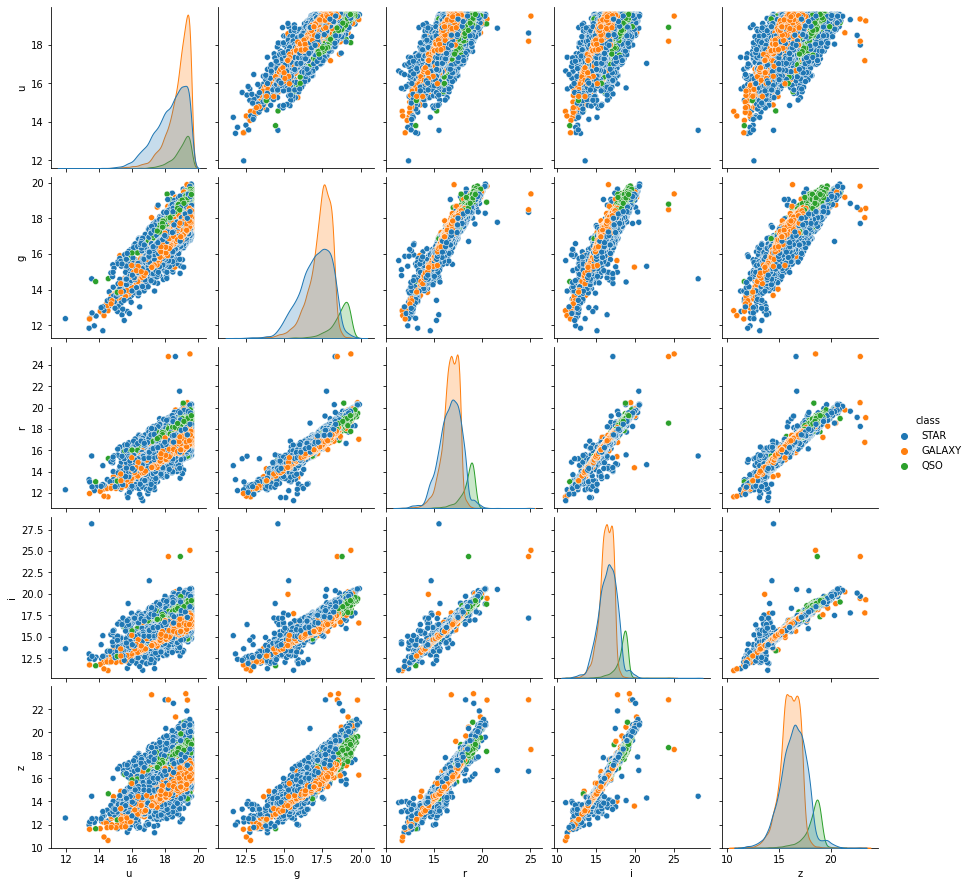

In [ ]:
## Multivariate analysis on features u,g,r,i,z using pairplots
## These are the multiple bands used for determination of the colors of the detected objects. These features are taken from the Image table.
## The scatter plot and the pdf shows that most of these features overlap for the three classes and the data is not linearly separable for these features.
## Pair plot allows us to see both distribution of a single variable and its relationship with other variables.

sns.pairplot(data[['u','g','r','i','z','class']], kind='scatter', hue="class")

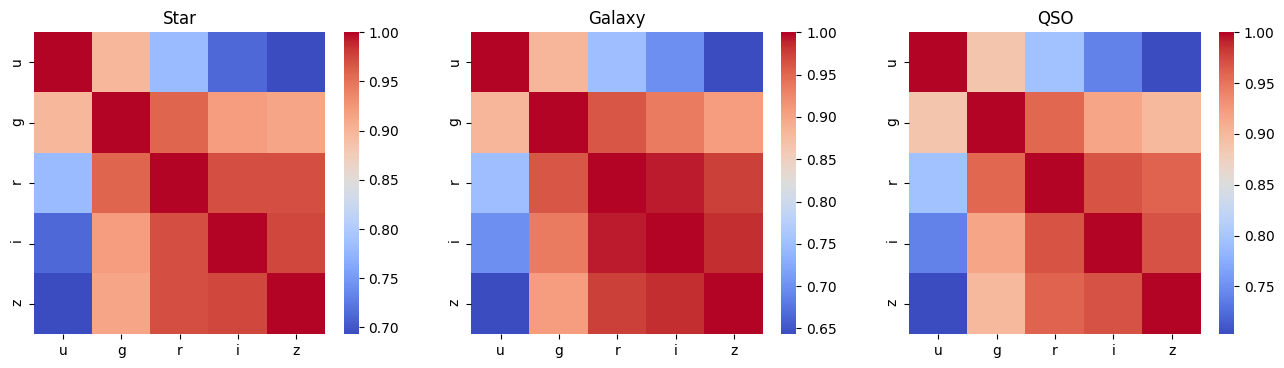

In [ ]:
## correaltion matrix
## https://www.kaggle.com/lucidlenn/data-analysis-and-classification-using-xgboost

## From here we see the band features are highly correlated except for u which also has a correlation coefficient above 0.7.
## So we cannot separate the classes with respect to band features.
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(data[data['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(data[data['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(data[data['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

<Figure size 432x288 with 0 Axes>

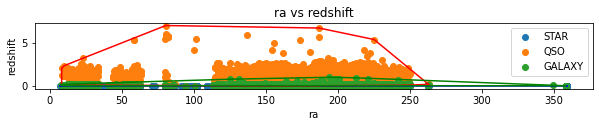

<Figure size 432x288 with 0 Axes>

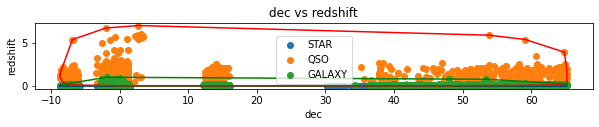

<Figure size 432x288 with 0 Axes>

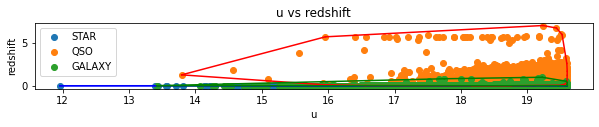

<Figure size 432x288 with 0 Axes>

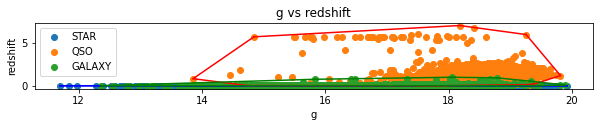

<Figure size 432x288 with 0 Axes>

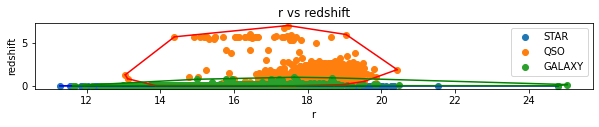

<Figure size 432x288 with 0 Axes>

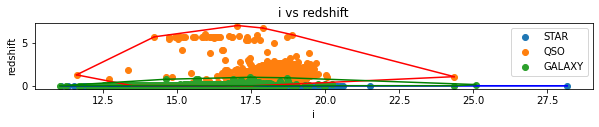

<Figure size 432x288 with 0 Axes>

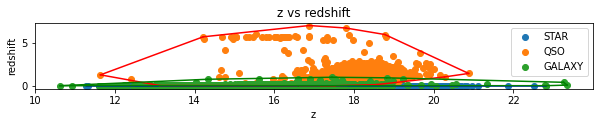

In [ ]:
##source : https://www.tarekatwan.com/index.php/2017/12/methods-for-testing-linear-separability-in-python/
##         https://www.researchgate.net/publication/324536351_Machine_Learning_in_Astronomy_A_Case_Study_in_Quasar-Star_Classification

## Another test for linear separabilty.
## Convex Hull with scatter plot is drawn for each feature with respect to redshift.
## Here features like Run, rerun, camcol and field which describe a field within an image taken by the SDSS are not used. 
## A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 


## Convex Hull of a shape or a group of points is a tight fitting convex boundary around the points or the shape. 
## The key idea is if the convex hull of at least two classes of any data set intersects or overlaps, 
## then it may be concluded that the classes in the data are not linearly separable. 

## It is observed that the majority of the data belonging to the class of quasars are not present within the convex hull of the 
## class of non-quasars when redshift is used with other feature respectively. 
## Thus, the two classes in the dataset are mostly linearly separable with redshift being the most important feature 
## and SVM can be used here. Since the data exhibits linear separability,it is sensible to use linear SVM.


names = list(set(data['class'].values))
feat = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z','redshift']
for i in range(len(feat)-1):

  plt.clf()
  plt.figure(figsize = (10, 10))
  plt.subplot(7,1,i+1)
  colors = ['b','r','g']
  plt.title(feat[i] + ' vs ' + feat[7])
  plt.xlabel(feat[i])
  plt.ylabel(feat[7])
  for k in range(len(names)):
      bucket = data[data['class'] == names[k]]
      bucket = bucket.loc[:,[feat[i],feat[7]]].values
      hull = ConvexHull(bucket)
      plt.scatter(bucket[:, 0], bucket[:, 1], label=names[k]) 
      for j in hull.simplices:
          plt.plot(bucket[j,0], bucket[j,1], colors[k])
  plt.legend()
  plt.show()

<Figure size 432x288 with 0 Axes>

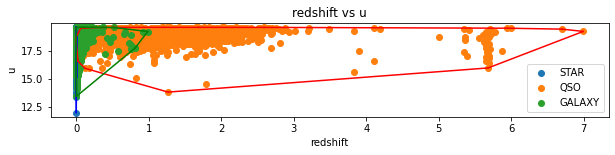

<Figure size 432x288 with 0 Axes>

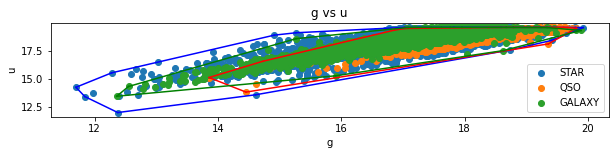

<Figure size 432x288 with 0 Axes>

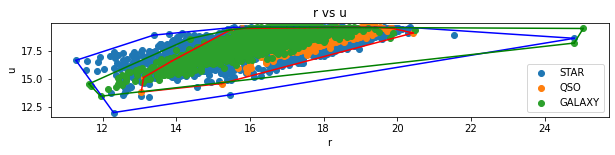

<Figure size 432x288 with 0 Axes>

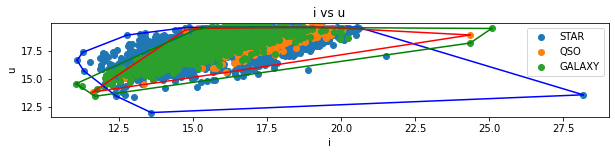

<Figure size 432x288 with 0 Axes>

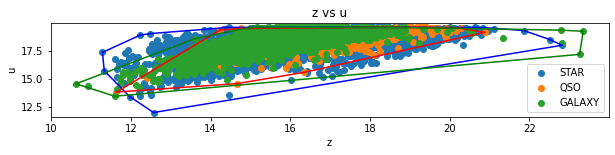

In [ ]:
## It is observed that the majority of the data belonging to the class of quasars are overlaps within the convex hull of the 
## class of non-quasars when band feature u is used with other band features respectively. 
## then it may be concluded that the band feature u is the feature where the data is not linearly separable and it is just in the first plot
## where redshift is a feature we can see linear separabilty. 

names = list(set(data['class'].values))
feat = ['redshift', 'g', 'r', 'i', 'z','u']
for i in range(len(feat)-1):

  plt.clf()
  plt.figure(figsize = (10, 10))
  plt.subplot(5,1,i+1)
  colors = ['b','r','g']
  plt.title(feat[i] + ' vs ' + feat[5])
  plt.xlabel(feat[i])
  plt.ylabel(feat[5])
  for k in range(len(names)):
      bucket = data[data['class'] == names[k]]
      bucket = bucket.loc[:,[feat[i],feat[5]]].values
      hull = ConvexHull(bucket)
      plt.scatter(bucket[:, 0], bucket[:, 1], label=names[k]) 
      for j in hull.simplices:
          plt.plot(bucket[j,0], bucket[j,1], colors[k])
  plt.legend()
  plt.show()

In [ ]:
feat = ['redshift','dec', 'ra', 'g', 'r', 'i', 'z','u']

Text(0.5, 1.0, 'Equatorial coordinates')

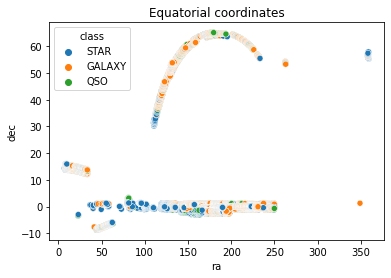

In [ ]:
## Source: https://en.wikipedia.org/wiki/Right_ascension

## declination when paired with Right_ascension, are astronomical coordinates 
## which specify the location of a point on the celestial sphere in the equatorial coordinate system

## scatter plot shows that ra and dec features are overlapping for all classes of points 
## thus it may be concluded that the probability to find a quasar is same as to find Galaxy or Star in a given region.

sns.scatterplot(x='ra', y='dec', data = data, hue='class')
plt.title('Equatorial coordinates')


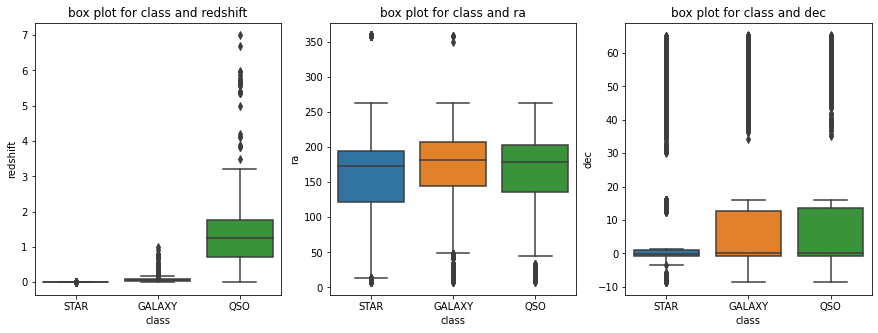

In [ ]:
## The box plot shows the distribution of numerical data and skewness through displaying the data quartiles (or percentiles) and averages.
## box plot for class dec shows 50% of quasar points have dec between 0-15. 
## 25% of non quasar points have dec around 0-5 and all are more positively skewed for dec box plot. 
## not much difference in values of ra for quasar and non quasar points and it is mostly normally distributed for 3 classes.
## IQR for redshift is very high for quasar as compared to non quasar points and it also shows normal distribution.

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='class', y='redshift', data=data, ax=axes[0]).set_title('box plot for class and redshift')
sns.boxplot(x='class', y='ra', data=data, ax=axes[1]).set_title('box plot for class and ra')
sns.boxplot(x='class', y='dec', data=data, ax=axes[2]).set_title('box plot for class and dec')
plt.show()

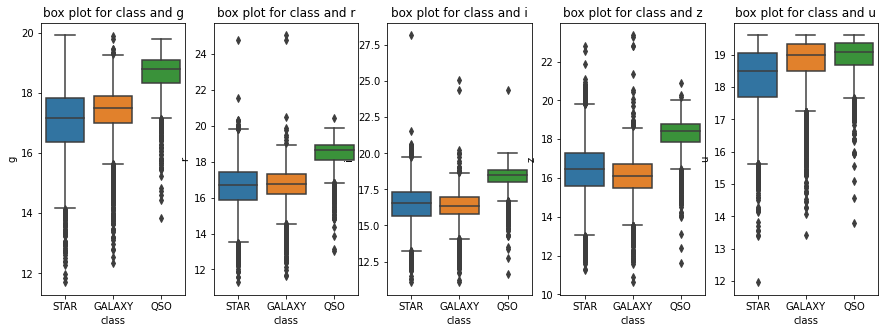

In [ ]:
## the box plot below is very informative as it shows that the IQR of u band is nearly same for all 3 class of points
## as we saw by plotting the convex hull for u against other band features. 
## the box plot of u for star points is positively skewed.

## Apart from u the other band features have high IQR for Quasar points as compared to other class of points.

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
sns.boxplot(x='class', y='g', data=data, ax=axes[0]).set_title('box plot for class and g')
sns.boxplot(x='class', y='r', data=data, ax=axes[1]).set_title('box plot for class and r')
sns.boxplot(x='class', y='i', data=data, ax=axes[2]).set_title('box plot for class and i')
sns.boxplot(x='class', y='z', data=data, ax=axes[3]).set_title('box plot for class and z')
sns.boxplot(x='class', y='u', data=data, ax=axes[4]).set_title('box plot for class and u')
plt.show()

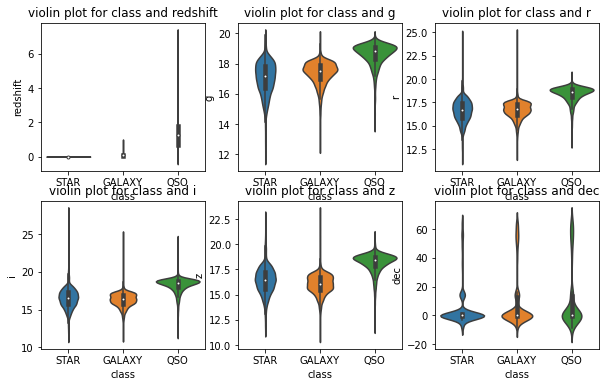

In [ ]:
## Voilin  for all the important features
## It shows the median i.e small white point of all the features plotted 
## is greater for quasar points as compared to non-quasar points.
## g,r,i
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
sns.violinplot(x='class', y='redshift', data=data, ax=axes[0][0]).set_title('violin plot for class and redshift')
sns.violinplot(x='class', y='g', data=data, ax=axes[0][1]).set_title('violin plot for class and g')
sns.violinplot(x='class', y='r', data=data, ax=axes[0][2]).set_title('violin plot for class and r')
sns.violinplot(x='class', y='i', data=data, ax=axes[1][0]).set_title('violin plot for class and i')
sns.violinplot(x='class', y='z', data=data, ax=axes[1][1]).set_title('violin plot for class and z')
sns.violinplot(x='class', y='dec', data=data, ax=axes[1][2]).set_title('violin plot for class and dec')
plt.show()

In [ ]:
## Since these features are highly correlated we can try dimentionality redution for them
d=data[['g','r','i','z','u']]
d=StandardScaler().fit_transform(d)

In [ ]:
model=TSNE(n_components=2,
    perplexity=1000.0,n_iter=100000,random_state=0)
tsne_data=model.fit_transform(d)

In [ ]:
l=data['class']
tsne_data=np.vstack((tsne_data.T,l)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dim_1","Dim_2","label"))
tsne_df.head()

In [ ]:
## Most of the data is overlapping with 2 dimensional representation of the band features.
sns.FacetGrid(tsne_df,hue='label',size=6).map(plt.scatter,"Dim_1","Dim_2").add_legend()
plt.title('2 dimensional plot showing the band features for 3 classes')
plt.show()

In [ ]:
dump(tsne_data, 'tsne_model.joblib')

In [ ]:
model2 = TSNE(n_components=3,
    perplexity=1000.0, n_iter=100000, random_state=0)
tsne_data = model2.fit_transform(d)

In [ ]:
l = data['class']
tsne_data2 = np.vstack((tsne_data.T,l)).T
tsne_df = pd.DataFrame(data=tsne_data2, columns=("Dim_1","Dim_2","Dim_3","label"))
tsne_df.head()

In [ ]:
## Multivariate analysis on features 3 dim band features using pairplots
## These are the multiple bands used for determination of the colors of the detected objects. These features are taken from the Image table.
## The scatter plot and the pdf shows that most of these features overlap for the three classes and the data is not linearly separable for these features.
## Pair plot allows us to see both distribution of a single variable and its relationship with other variables.
x = tsne_df[['Dim_1','Dim_2','Dim_3']].astype(float)
x['label'] = tsne_df['label']
sns.pairplot(x, kind='scatter',hue = 'label')

In [ ]:
dump(tsne_data, 'tsne_model2.joblib')

# TSNE data load

In [ ]:
tsne_data = load('tsne_model2.joblib')

In [ ]:
l = data['class']
tsne_data2 = np.vstack((tsne_data.T,l)).T
tsne_df = pd.DataFrame(data=tsne_data2, columns=("Dim_1","Dim_2","Dim_3","label"))
tsne_df.head()

,Dim_1,Dim_2,Dim_3,label
0,-2.07295,1.71117,-5.10217,STAR
1,-6.47977,0.474292,2.49486,STAR
2,13.5804,-2.08177,-5.92983,GALAXY
3,-0.585119,-1.02367,2.75555,STAR
4,6.80496,2.32151,-7.76742,STAR


# Conclusion
1.   The most important feature is Redshift.
2.   Bar plot is shown to visualise class imbalance.
3.   pdf drwan for dec, ra and redshift.
4.   Pair plots for the band features shows most of the overlap.
5.   Correlation matrix shows there is correlation between the band features are high but its less for band u
6.   The Convex Hull drwan for redshift with respect to other features shows data is separable into 3 classes for redshift.
7.   The convex Hull for u with other features respectively shows that the band feature u is the feature where the data is not linearly separable.
8. Scatter plot for ra and de shows most of points for each class are mostly found the same reqion.
9. Bar plot showed the skewness in the numerical values.
10. Tsne on the band features into 2 dimensional and 3 dimensional to visualize . 



# Band_features converted to 3 dim and final data created



In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['cl_label']=le.fit_transform(data['class'])
tsne_df['cl_label'] = le.transform(tsne_df['label'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
tsne_df['cl_label'].value_counts()

2    9140
0    9109
1    1710
Name: cl_label, dtype: int64

In [ ]:
df = pd.concat([data[['ra', 'dec', 'redshift','class','img_path','cl_label']] , tsne_df.drop('label',axis=1).drop('cl_label',axis=1)], axis=1)
df.head()

,ra,dec,redshift,class,img_path,cl_label,Dim_1,Dim_2,Dim_3
0,224.367913,0.492218,0.000256,STAR,/content/img/captcha0.png,2.0,-2.07295,1.71117,-5.10217
1,224.469246,0.532670,0.000687,STAR,/content/img/captcha1.png,2.0,-6.47977,0.474292,2.49486
2,224.379514,0.437444,0.083711,GALAXY,/content/img/captcha2.png,0.0,13.5804,-2.08177,-5.92983
3,224.502897,0.497601,-0.000022,STAR,/content/img/captcha3.png,2.0,-0.585119,-1.02367,2.75555
4,224.506416,0.568373,-0.000084,STAR,/content/img/captcha4.png,2.0,6.80496,2.32151,-7.76742


In [ ]:
df['cl_label'].value_counts()

2.0    9140
0.0    9109
1.0    1710
Name: cl_label, dtype: int64

# Train_test_split 

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]
df=clean_dataset(df)

In [ ]:
df['cl_label'].value_counts(),df['class'].value_counts()

(2.0    9120
 0.0    9088
 1.0    1710
 Name: cl_label, dtype: int64, STAR      9120
 GALAXY    9088
 QSO       1710
 Name: class, dtype: int64)

In [ ]:
X = df.drop('class',axis=1).drop('cl_label',axis=1)
y = df['cl_label']
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_tr, X_c, y_tr, y_c = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [ ]:
Counter(y_test),Counter(y_tr),Counter(y_c)

(Counter({0.0: 2272, 1.0: 428, 2.0: 2280}),
 Counter({0.0: 4566, 1.0: 859, 2.0: 4583}),
 Counter({0.0: 2250, 1.0: 423, 2.0: 2257}))

## Data split in the ratio of 2:1:1 approx

In [ ]:
X_c.shape ,y_c.shape## cross validation set

((4930, 7), (4930,))

In [ ]:
X_tr.shape, y_tr.shape ## train set

((10008, 7), (10008,))

In [ ]:
X_test.shape, y_test.shape ##test set

((4980, 7), (4980,))

# Faeture Engineering

In [ ]:
classes = y_tr.values
data = X_tr.drop('img_path',axis=1) 

In [ ]:
classes.shape,data.shape

((10008,), (10008, 6))

In [ ]:
adasyn = ADASYN(sampling_strategy='minority', random_state=8, n_neighbors=3)
new_data, new_classes = adasyn.fit_resample(data, classes)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=2, n=4583 (33.900%)
Class=1, n=4370 (32.325%)
Class=0, n=4566 (33.775%)


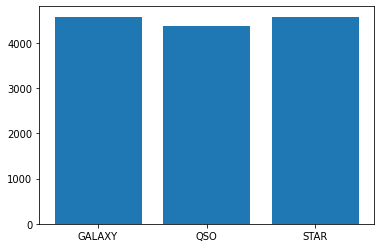

In [ ]:
counter = Counter(new_classes)
for k,v in counter.items():
	per = v / len(new_classes) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(['GALAXY',"QSO",'STAR'], counter.values())
plt.show()

In [ ]:
X_train = pd.DataFrame(new_data,columns=list(data.columns)) 
y_train = pd.DataFrame(new_classes,columns=['class'])

Class=2, n=2257 (33.422%)
Class=0, n=2250 (33.319%)
Class=1, n=2246 (33.259%)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


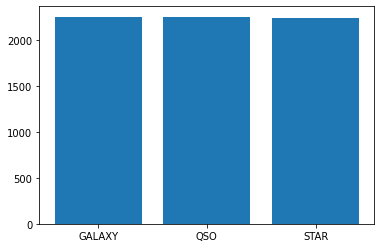

In [ ]:
X_cc = X_c.drop('img_path',axis=1)
x_cv, y_cvv = adasyn.fit_resample(X_cc, y_c)
X_cv = pd.DataFrame(x_cv,columns=list(X_cc.columns))
y_cv = pd.DataFrame(y_cvv,columns=['class'])
counter = Counter(y_cvv)
for k,v in counter.items():
	per = v / len(y_cvv) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(['GALAXY',"QSO",'STAR'], counter.values())
plt.show()

In [ ]:
df.to_csv('final_df.csv',index=False)

# First Cut Approach Model traing

## Numerical_Values

In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['ra'].values.reshape(1,-1))

X_train_ra_norm = normalizer.transform(X_train['ra'].values.reshape(1,-1)).reshape(-1,1)
X_cv_ra_norm = normalizer.transform(X_cv['ra'].values.reshape(1,-1)).reshape(-1,1)
X_test_ra_norm = normalizer.transform(X_test['ra'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_ra.sav', 'wb'))

print(X_train_ra_norm.shape, y_train.shape)
print(X_cv_ra_norm.shape, y_cv.shape)
print(X_test_ra_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['dec'].values.reshape(1,-1))

X_train_dec_norm = normalizer.transform(X_train['dec'].values.reshape(1,-1)).reshape(-1,1)
X_cv_dec_norm = normalizer.transform(X_cv['dec'].values.reshape(1,-1)).reshape(-1,1)
X_test_dec_norm = normalizer.transform(X_test['dec'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_dec.sav', 'wb'))

print(X_train_dec_norm.shape, y_train.shape)
print(X_cv_dec_norm.shape, y_cv.shape)
print(X_test_dec_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['redshift'].values.reshape(1,-1))

X_train_redshift_norm = normalizer.transform(X_train['redshift'].values.reshape(1,-1)).reshape(-1,1)
X_cv_redshift_norm = normalizer.transform(X_cv['redshift'].values.reshape(1,-1)).reshape(-1,1)
X_test_redshift_norm = normalizer.transform(X_test['redshift'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_redshift.sav', 'wb'))

print(X_train_redshift_norm.shape, y_train.shape)
print(X_cv_redshift_norm.shape, y_cv.shape)
print(X_test_redshift_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['Dim_1'].values.reshape(1,-1))

X_train_Dim_1_norm = normalizer.transform(X_train['Dim_1'].values.reshape(1,-1)).reshape(-1,1)
X_cv_Dim_1_norm = normalizer.transform(X_cv['Dim_1'].values.reshape(1,-1)).reshape(-1,1)
X_test_Dim_1_norm = normalizer.transform(X_test['Dim_1'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_Dim_1.sav', 'wb'))

print(X_train_Dim_1_norm.shape, y_train.shape)
print(X_cv_Dim_1_norm.shape, y_cv.shape)
print(X_test_Dim_1_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['Dim_2'].values.reshape(1,-1))

X_train_Dim_2_norm = normalizer.transform(X_train['Dim_2'].values.reshape(1,-1)).reshape(-1,1)
X_cv_Dim_2_norm = normalizer.transform(X_cv['Dim_2'].values.reshape(1,-1)).reshape(-1,1)
X_test_Dim_2_norm = normalizer.transform(X_test['Dim_2'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_Dim_2.sav', 'wb'))

print(X_train_Dim_2_norm.shape, y_train.shape)
print(X_cv_Dim_2_norm.shape, y_cv.shape)
print(X_test_Dim_2_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
normalizer = Normalizer()

normalizer.fit(X_train['Dim_3'].values.reshape(1,-1))

X_train_Dim_3_norm = normalizer.transform(X_train['Dim_3'].values.reshape(1,-1)).reshape(-1,1)
X_cv_Dim_3_norm = normalizer.transform(X_cv['Dim_3'].values.reshape(1,-1)).reshape(-1,1)
X_test_Dim_3_norm = normalizer.transform(X_test['Dim_3'].values.reshape(1,-1)).reshape(-1,1)

pkl.dump(normalizer, open('normalizer_Dim_3.sav', 'wb'))

print(X_train_Dim_3_norm.shape, y_train.shape)
print(X_cv_Dim_3_norm.shape, y_cv.shape)
print(X_test_Dim_3_norm.shape, y_test.shape)

(13519, 1) (13519, 1)
(6753, 1) (6753, 1)
(4980, 1) (4980,)


In [ ]:
X_tr_hstack = hstack(( coo_matrix(X_train_ra_norm),X_train_dec_norm,X_train_redshift_norm,X_train_Dim_1_norm,X_train_Dim_2_norm,X_train_Dim_3_norm)).tocsr()
X_cr_hstack = hstack(( coo_matrix(X_cv_ra_norm),X_cv_dec_norm,X_cv_redshift_norm,X_cv_Dim_1_norm,X_cv_Dim_2_norm,X_cv_Dim_3_norm)).tocsr()
X_te_hstack = hstack(( coo_matrix(X_test_ra_norm),X_test_dec_norm,X_test_redshift_norm,X_test_Dim_1_norm,X_test_Dim_2_norm,X_test_Dim_3_norm)).tocsr()

##KNN

In [ ]:
y_train = pd.Series(y_train['class']) 
y_cv = pd.Series(y_cv['class']) 


In [ ]:
param_grid = {'n_neighbors':range(1,20)}
neigh = KNeighborsClassifier(weights='distance', metric='cosine')
clf = GridSearchCV(neigh, param_grid,cv=5,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf.fit(X_tr_hstack, y_train.values)
k = clf.best_params_['n_neighbors']

neigh2 = KNeighborsClassifier( weights='distance', metric='euclidean')
clf2 = GridSearchCV(neigh2, param_grid,cv=5,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf2.fit(X_tr_hstack, y_train.values)
k2 = clf2.best_params_['n_neighbors']

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  6.2min finished


In [ ]:
k,k2

(12, 7)

In [ ]:
model_knn_cosine = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')
model_knn_cosine.fit(X_tr_hstack, y_train) 
y_pred_train_cos = model_knn_cosine.predict(X_tr_hstack)

model_knn_euc = KNeighborsClassifier(n_neighbors=k2, weights='distance', metric='euclidean')
model_knn_euc.fit(X_tr_hstack, y_train) 
y_pred_train_euc = model_knn_euc.predict(X_tr_hstack)

In [ ]:
pkl.dump(model_knn_cosine, open('model_knn_cosine.sav', 'wb'))
pkl.dump(model_knn_euc, open('model_knn_euc.sav', 'wb'))

In [ ]:
f1_knn_euc_train = f1_score(y_train, y_pred_train_cos, average='weighted')
f1_knn_cos_train = f1_score(y_train, y_pred_train_euc, average='weighted')

f1_knn_euc_train,f1_knn_cos_train

(1.0, 1.0)

In [ ]:
y_pred_cv_knn_cos = model_knn_cosine.predict(X_cr_hstack)
y_pred_cv_knn_euc = model_knn_euc.predict(X_cr_hstack)

f1_knn_cos_cv= f1_score(y_cv, y_pred_cv_knn_cos, average='weighted')
f1_knn_euc_cv= f1_score(y_cv, y_pred_cv_knn_euc, average='weighted')

f1_knn_cos_cv,f1_knn_euc_cv

(0.843390548572383, 0.7357822877667294)

In [ ]:
y_pred_test_knn_cos = model_knn_cosine.predict(X_te_hstack)
y_pred_test_knn_euc = model_knn_euc.predict(X_te_hstack)

f1_knn_test_cos = f1_score(y_test, y_pred_test_knn_cos, average='weighted')
f1_knn_test_euc = f1_score(y_test, y_pred_test_knn_euc, average='weighted')
f1_knn_test_cos,f1_knn_test_euc

(0.8638959956966387, 0.6297337733388276)

In [ ]:
label = ["GALAXY:0","QSO:1",'STAR:2']
confusion_matrix(y_test,y_pred_test_knn_cos)

array([[1973,   65,  234],
       [  30,  397,    1],
       [ 347,    1, 1932]])

In [ ]:
tp_knn_cos, fp_knn_cos,fn_knn_cos = confusion_matrix(y_test,y_pred_test_knn_cos)[1][1],\
                                    confusion_matrix(y_test,y_pred_test_knn_cos)[0][1] +confusion_matrix(y_test,y_pred_test_knn_cos)[2][1],\
                                    confusion_matrix(y_test,y_pred_test_knn_cos)[1][0] + confusion_matrix(y_test,y_pred_test_knn_cos)[1][2]

tp_knn_euc, fp_knn_euc, fn_knn_euc = confusion_matrix(y_test,y_pred_test_knn_euc)[1][1],\
                                     confusion_matrix(y_test,y_pred_test_knn_euc)[0][1] +confusion_matrix(y_test,y_pred_test_knn_euc)[2][1],\
                                     confusion_matrix(y_test,y_pred_test_knn_euc)[1][0] + confusion_matrix(y_test,y_pred_test_knn_euc)[1][2]

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_knn_cos, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.84      0.87      0.85      2272
       QSO:1       0.86      0.93      0.89       428
      STAR:2       0.89      0.85      0.87      2280

    accuracy                           0.86      4980
   macro avg       0.86      0.88      0.87      4980
weighted avg       0.86      0.86      0.86      4980



In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_knn_euc, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.58      0.77      0.66      2272
       QSO:1       0.73      0.94      0.82       428
      STAR:2       0.74      0.45      0.56      2280

    accuracy                           0.64      4980
   macro avg       0.68      0.72      0.68      4980
weighted avg       0.66      0.64      0.63      4980



##Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
clf1=DecisionTreeClassifier()
depth={'max_depth':[1, 5, 10, 50]}
clf_depth=GridSearchCV(clf1,depth,cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf_depth.fit(X_tr_hstack, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50]}, pre_dispatch='2*n_jobs',

In [ ]:
max_depth=clf_depth.best_params_['max_depth']
max_depth

5

In [ ]:
model_dt = DecisionTreeClassifier(max_depth = max_depth)

In [ ]:
model_dt.fit(X_tr_hstack, y_train) 
y_pred_train_dt = model_dt.predict(X_tr_hstack)

In [ ]:
pkl.dump(model_dt, open('model_dt.sav', 'wb'))

In [ ]:
from sklearn.metrics import f1_score
f1_dt_train = f1_score(y_train, y_pred_train_dt, average='weighted')
f1_dt_train

0.9871221122828263

In [ ]:
y_pred_cv_dt = model_dt.predict(X_cr_hstack)
f1_dt_cv= f1_score(y_cv, y_pred_cv_dt, average='weighted')
f1_dt_cv

0.9526056388218704

In [ ]:
y_pred_test_dt = model_dt.predict(X_te_hstack)
f1_dt_test = f1_score(y_test, y_pred_test_dt, average='weighted')
f1_dt_test

0.7706223283171624

In [ ]:
tp_dt, fp_dt ,fn_dt = confusion_matrix(y_test,y_pred_test_dt)[1][1],\
                      confusion_matrix(y_test,y_pred_test_dt)[0][1] +confusion_matrix(y_test,y_pred_test_dt)[2][1],\
                      confusion_matrix(y_test,y_pred_test_dt)[1][0] + confusion_matrix(y_test,y_pred_test_dt)[1][2]

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_dt, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.97      0.45      0.62      2272
       QSO:1       0.26      0.99      0.41       428
      STAR:2       0.99      0.99      0.99      2280

    accuracy                           0.74      4980
   macro avg       0.74      0.81      0.67      4980
weighted avg       0.92      0.74      0.77      4980



## Xgboost

In [ ]:
model = XGBClassifier()
depth={'max_depth':[1, 5, 10, 50]}
xgboost_depth=GridSearchCV(model,depth,cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
xgboost_depth.fit(X_tr_hstack, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring='roc_auc_ovr',
             verbose=10)

In [ ]:
max_depth2=xgboost_depth.best_params_['max_depth']
max_depth2

50

In [ ]:
model_xgboost = XGBClassifier(max_depth = max_depth2)

In [ ]:
model_xgboost.fit(X_tr_hstack, y_train) 
y_pred_train_xgboost = model_xgboost.predict(X_tr_hstack)

In [ ]:
pkl.dump(model_xgboost, open('model_xgboost.sav', 'wb'))

In [ ]:
f1_xgb_train = f1_score(y_train, y_pred_train_xgboost, average='weighted')
f1_xgb_train

0.9999260300159002

In [ ]:
y_pred_cv_xgboost = model_xgboost.predict(X_cr_hstack)
f1_xgboost_cv= f1_score(y_cv, y_pred_cv_xgboost, average='weighted')
f1_xgboost_cv

0.9779279684533563

In [ ]:
y_pred_test_xgboost = model_xgboost.predict(X_te_hstack)
f1_xgboost_test = f1_score(y_test, y_pred_test_xgboost, average='weighted')
f1_xgboost_test

0.8063207546702138

In [ ]:
tp_xgb, fp_xgb ,fn_xgb = confusion_matrix(y_test,y_pred_test_xgboost)[1][1],\
                      confusion_matrix(y_test,y_pred_test_xgboost)[0][1] +confusion_matrix(y_test,y_pred_test_xgboost)[2][1],\
                      confusion_matrix(y_test,y_pred_test_xgboost)[1][0] + confusion_matrix(y_test,y_pred_test_xgboost)[1][2]

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_xgboost, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.98      0.53      0.69      2272
       QSO:1       0.28      0.99      0.44       428
      STAR:2       1.00      0.99      0.99      2280

    accuracy                           0.78      4980
   macro avg       0.75      0.84      0.71      4980
weighted avg       0.93      0.78      0.81      4980



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid,cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf.fit(X_tr_hstack, y_train)
c = clf.best_params_['C']

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1236s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.6s finished


In [ ]:
c

10

In [ ]:
model_LR = LogisticRegression(C=c)
model_LR.fit(X_tr_hstack, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pkl.dump(model_LR, open('model_LR.sav', 'wb'))

In [ ]:
y_pred_train_lr = model_LR.predict(X_tr_hstack)
f1_LR_train = f1_score(y_train, y_pred_train_lr, average='weighted')
f1_LR_train

0.6136285738327422

In [ ]:
y_pred_cv_LR = model_LR.predict(X_cr_hstack)
f1_lsvm_cv_LR = f1_score(y_cv, y_pred_cv_LR, average='weighted')
f1_lsvm_cv_LR

0.7227801054207308

In [ ]:
y_pred_test_LR = model_LR.predict(X_te_hstack)
f1_lsvm_test_LR = f1_score(y_test, y_pred_test_LR, average='weighted')
f1_lsvm_test_LR

0.6809376087877769

In [ ]:
tp_lr, fp_lr ,fn_lr = confusion_matrix(y_test,y_pred_test_LR)[1][1],\
                      confusion_matrix(y_test,y_pred_test_LR)[0][1] +confusion_matrix(y_test,y_pred_test_LR)[2][1],\
                      confusion_matrix(y_test,y_pred_test_LR)[1][0] + confusion_matrix(y_test,y_pred_test_LR)[1][2]

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_LR, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.62      0.82      0.70      2272
       QSO:1       0.95      0.94      0.94       428
      STAR:2       0.74      0.51      0.61      2280

    accuracy                           0.69      4980
   macro avg       0.77      0.76      0.75      4980
weighted avg       0.71      0.69      0.68      4980



## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
clf = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=clf, param_grid=params_NB,cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
gs_NB.fit(X_tr_hstack.toarray(), y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0518s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1313s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    7.3s
[Parallel(n_jo

In [ ]:
a = gs_NB.best_params_['var_smoothing']

In [ ]:
a

3.5111917342151275e-06

In [ ]:
model_gnb = GaussianNB(var_smoothing=a)
model_gnb.fit(X_tr_hstack.todense(),y_train)
y_pred_train_gnb=model_gnb.predict(X_tr_hstack.todense())

In [ ]:
pkl.dump(model_gnb, open('model_gnb.sav', 'wb'))

In [ ]:
f1_gnb_train = f1_score(y_train, y_pred_train_gnb, average='weighted')
f1_gnb_train

0.9846739937104546

In [ ]:
y_pred_cv_gnb = model_gnb.predict(X_cr_hstack.todense())
f1_lsvm_cv_gnb = f1_score(y_cv, y_pred_cv_gnb, average='weighted')
f1_lsvm_cv_gnb

0.957313969461141

In [ ]:
y_pred_test_gnb = model_gnb.predict(X_te_hstack.todense())
f1_lsvm_test_gnb = f1_score(y_test, y_pred_test_gnb, average='weighted')
f1_lsvm_test_gnb

0.7717921846419548

In [ ]:
tp_nb, fp_nb ,fn_nb = confusion_matrix(y_test,y_pred_test_gnb)[1][1],\
                      confusion_matrix(y_test,y_pred_test_gnb)[0][1] +confusion_matrix(y_test,y_pred_test_gnb)[2][1],\
                      confusion_matrix(y_test,y_pred_test_gnb)[1][0] + confusion_matrix(y_test,y_pred_test_gnb)[1][2]

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_gnb, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.87      0.51      0.65      2272
       QSO:1       0.28      0.98      0.43       428
      STAR:2       0.99      0.93      0.96      2280

    accuracy                           0.74      4980
   macro avg       0.71      0.81      0.68      4980
weighted avg       0.88      0.74      0.77      4980



## SVM model

In [ ]:
from sklearn import svm
clf1 = svm.SVC(kernel='linear',probability=True)
C=[]
for i in range(-5,4,1):
  C.append(2**i)
clf = GridSearchCV(clf1,{'C':C},cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf.fit(X_tr_hstack, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 41.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc_ovr', verbose=10)

In [ ]:
pkl.dump(clf, open('svm_model25.sav', 'wb'))

In [ ]:
c1=clf.best_params_['C']

In [ ]:
c1

8

In [ ]:
from sklearn import svm
model_lsvm = svm.SVC(C=c1,kernel='linear')

In [ ]:
model_lsvm.fit(X_tr_hstack, y_train)

SVC(C=8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pkl.dump(model_lsvm, open('svm_linear.sav', 'wb'))

In [ ]:
y_pred_train_lsvm = model_lsvm.predict(X_tr_hstack)

In [ ]:
f1_lsvm_train = f1_score(y_train, y_pred_train_lsvm, average='weighted')
f1_lsvm_train

0.5841575959020697

In [ ]:
y_pred_cv_lsvm = model_lsvm.predict(X_cr_hstack)
f1_lsvm_cv = f1_score(y_cv, y_pred_cv_lsvm, average='weighted')
f1_lsvm_cv

0.5879033733592722

In [ ]:
y_pred_test_lsvm = model_lsvm.predict(X_te_hstack)
f1_lsvm_test = f1_score(y_test, y_pred_test_lsvm, average='weighted')
f1_lsvm_test

0.502944481601489

In [ ]:
tp_lsvm, fp_lsvm ,fn_lsvm = confusion_matrix(y_test,y_pred_test_lsvm)[1][1],\
                      confusion_matrix(y_test,y_pred_test_lsvm)[0][1] + confusion_matrix(y_test,y_pred_test_lsvm)[2][1],\
                      confusion_matrix(y_test,y_pred_test_lsvm)[1][0] + confusion_matrix(y_test,y_pred_test_lsvm)[1][2]

In [ ]:
clf1 = svm.SVC(C=4,probability=True,kernel='rbf')
C2=[]
for i in range(-5,4,1):
  C2.append(2**i)
clf = GridSearchCV(clf1,{'C':C2},cv=10,scoring='roc_auc_ovr',return_train_score=True,n_jobs=-1,verbose=10)
clf.fit(X_tr_hstack, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 27.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=4, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc_ovr', verbose=10)

In [ ]:
c2 = clf.best_params_['C']

In [ ]:
c2

8

In [ ]:
model_rbfsvm = svm.SVC(C=c2,kernel='rbf')

In [ ]:
model_rbfsvm.fit(X_tr_hstack, y_train)

SVC(C=8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pkl.dump(model_rbfsvm, open('model_rbfsvm.sav', 'wb'))

In [ ]:
y_pred_train_rbfsvm = model_lsvm.predict(X_tr_hstack)

In [ ]:
f1_rbfsvm_train = f1_score(y_train, y_pred_train_rbfsvm, average='weighted')
f1_rbfsvm_train

0.5841575959020697

In [ ]:
y_pred_test_rbfsvm = model_rbfsvm.predict(X_te_hstack)
f1_rbfsvm_test = f1_score(y_test, y_pred_test_rbfsvm, average='weighted')
f1_rbfsvm_test

0.8184813767145985

In [ ]:
y_pred_cv_rbfsvm = model_rbfsvm.predict(X_cr_hstack)
f1_rbfsvm_cv = f1_score(y_cv, y_pred_cv_rbfsvm, average='weighted')
f1_rbfsvm_cv

0.9354091236457727

In [ ]:
tp_te_rbf, fp_te_rbf ,fn_te_rbf = confusion_matrix(y_test,y_pred_test_rbfsvm)[1][1],\
                      confusion_matrix(y_test,y_pred_test_rbfsvm)[0][1] +confusion_matrix(y_test,y_pred_test_rbfsvm)[2][1],\
                      confusion_matrix(y_test,y_pred_test_rbfsvm)[1][0] + confusion_matrix(y_test,y_pred_test_rbfsvm)[1][2]

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_lsvm, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.65      0.16      0.26      2272
       QSO:1       0.98      0.90      0.94       428
      STAR:2       0.52      0.92      0.67      2280

    accuracy                           0.57      4980
   macro avg       0.72      0.66      0.62      4980
weighted avg       0.62      0.57      0.50      4980



In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_test_rbfsvm, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       0.91      0.67      0.77      2272
       QSO:1       0.31      0.63      0.42       428
      STAR:2       0.91      0.97      0.94      2280

    accuracy                           0.81      4980
   macro avg       0.71      0.76      0.71      4980
weighted avg       0.86      0.81      0.82      4980



In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "Overall_f1", "Precision_QSO","Recall_QSO","FP_QSO","FN_QSO","TP_QSO"]
x.add_rows(
    [
        ["KNN_cos", k, round(f1_knn_test_cos,2),\
          round(tp_knn_cos/(tp_knn_cos+fp_knn_cos),2),\
         round(tp_knn_cos/(tp_knn_cos+fn_knn_cos),2), fp_knn_cos, fn_knn_cos, tp_knn_cos],\
     
        ["KNN_euc",k2, round(f1_knn_test_euc,2),\
         round(tp_knn_euc/(tp_knn_euc+fp_knn_euc),2),\
         round(tp_knn_euc/(tp_knn_euc+fn_knn_euc),2), fp_knn_euc, fn_knn_euc, tp_knn_euc],\
     
        ["Decision_Tree", max_depth, round(f1_dt_test,2),\
         round(tp_dt/(tp_dt+fp_dt),2),\
         round(tp_dt/(tp_dt+fn_dt),2), fp_dt, fn_dt, tp_dt],\
     
        ["Xgboost", max_depth2, round(f1_xgboost_test,2),\
         round(tp_xgb/(tp_xgb+fp_xgb),2),\
         round(tp_xgb/(tp_xgb+fn_xgb),2), fp_xgb, fn_xgb, tp_xgb],\
        
        ["LogisticRegression", c, round(f1_lsvm_test_LR,2),\
         round(tp_lr/(tp_lr+fp_lr),2),\
         round(tp_lr/(tp_lr+fn_lr),2), fp_lr, fn_lr, tp_lr],\
        
        ["Gaussian Naive Bayes", a, round(f1_lsvm_test_gnb,2),\
         round(tp_nb/(tp_nb+fp_nb),2),\
         round(tp_nb/(tp_nb+fn_nb),2), fp_nb, fn_nb, tp_nb],\
     
        ["SVM_linear", c1, round(f1_lsvm_test,2),\
         round(tp_lsvm/(tp_lsvm+fp_lsvm),2),\
         round(tp_lsvm/(tp_lsvm+fn_lsvm),2), fp_lsvm, fn_lsvm, tp_lsvm],\
        
        ["SVM_rbf", c2, round(f1_rbfsvm_test,2),\
         round(tp_te_rbf/(tp_te_rbf+fp_te_rbf),2),\
         round(tp_te_rbf/(tp_te_rbf+fn_te_rbf),2) ,fp_te_rbf, fn_te_rbf, tp_te_rbf]
    ]
)
print(x)

+----------------------+------------------------+------------+---------------+------------+--------+--------+--------+
|        Model         |     Hyperparameter     | Overall_f1 | Precision_QSO | Recall_QSO | FP_QSO | FN_QSO | TP_QSO |
+----------------------+------------------------+------------+---------------+------------+--------+--------+--------+
|       KNN_cos        |           12           |    0.86    |      0.86     |    0.93    |   66   |   31   |  397   |
|       KNN_euc        |           7            |    0.63    |      0.73     |    0.94    |  150   |   25   |  403   |
|    Decision_Tree     |           5            |    0.77    |      0.26     |    0.99    |  1225  |   3    |  425   |
|       Xgboost        |           50           |    0.81    |      0.28     |    0.99    |  1065  |   6    |  422   |
|  LogisticRegression  |           10           |    0.68    |      0.95     |    0.94    |   23   |   26   |  402   |
| Gaussian Naive Bayes | 3.5111917342151275e-06 

## Missclassified points in cross validation set and test set that is 75% of data from the base models respectively.

In [ ]:
## Xgboost
misclassified_points_xgb = []
for i in range(y_pred_cv_xgboost.shape[0]):
    if list(y_cv.values)[i] != list(y_pred_cv_xgboost)[i]:
      misclassified_points_xgb.append(i)
misclassified_points_tr_xgb = []
for i in range(y_pred_train_xgboost.shape[0]):
    if list(y_train.values)[i] != list(y_pred_train_xgboost)[i]:
      misclassified_points_tr_xgb.append(i)

##GNB
misclassified_points_gnb = []
for i in range(y_pred_cv_gnb.shape[0]):
    if list(y_cv.values)[i] != list(y_pred_cv_gnb)[i]:
      misclassified_points_gnb.append(i)
misclassified_points_tr_gnb = []
for i in range(y_pred_train_gnb.shape[0]):
    if list(y_train.values)[i] != list(y_pred_train_gnb)[i]:
      misclassified_points_tr_gnb.append(i)

## KNN cos
misclassified_points_knn = []
for i in range(y_pred_cv_knn_cos.shape[0]):
    if list(y_cv.values)[i] != list(y_pred_cv_knn_cos)[i]:
      misclassified_points_knn.append(i)
misclassified_points_tr_knn = []
for i in range(y_pred_train_cos.shape[0]):
    if list(y_train.values)[i] != list(y_pred_train_cos)[i]:
      misclassified_points_tr_knn.append(i)


##Logistic
misclassified_points_lr = []
for i in range(y_pred_cv_LR.shape[0]):
    if list(y_cv.values)[i] != list(y_pred_cv_LR)[i]:
      misclassified_points_lr.append(i)
misclassified_points_tr_lr = []
for i in range(y_pred_train_lr.shape[0]):
    if list(y_train.values)[i] != list(y_pred_train_lr)[i]:
      misclassified_points_tr_lr.append(i)

##lsvm
misclassified_points_lsvm = []
for i in range(y_pred_cv_lsvm.shape[0]):
    if list(y_cv.values)[i] != list(y_pred_cv_lsvm)[i]:
      misclassified_points_lsvm.append(i)
misclassified_points_tr_lsvm = []
for i in range(y_pred_train_lsvm.shape[0]):
    if list(y_train.values)[i] != list(y_pred_train_lsvm)[i]:
      misclassified_points_tr_lsvm.append(i)



In [ ]:
mis_points_knn = np.vstack((X_cr_hstack[misclassified_points_knn].todense(),X_tr_hstack[misclassified_points_tr_knn].todense()))
mis_points_lr = np.vstack((X_cr_hstack[misclassified_points_lr].todense(),X_tr_hstack[misclassified_points_tr_lr].todense()))
mis_points_gnb = np.vstack((X_cr_hstack[misclassified_points_gnb].todense(),X_tr_hstack[misclassified_points_tr_gnb].todense()))
mis_points_lsvm = np.vstack((X_cr_hstack[misclassified_points_lsvm].todense(),X_tr_hstack[misclassified_points_tr_lsvm].todense()))
mis_points_xgb = np.vstack((X_cr_hstack[misclassified_points_xgb].todense(),X_tr_hstack[misclassified_points_tr_xgb].todense()))

In [ ]:
mis_points_y_knn = np.vstack((y_cv.values[misclassified_points_knn].reshape(-1,1),y_train.values[misclassified_points_tr_knn].reshape(-1,1))).reshape(-1,)
mis_points_y_lr = np.vstack((y_cv.values[misclassified_points_lr].reshape(-1,1),y_train.values[misclassified_points_tr_lr].reshape(-1,1))).reshape(-1,)
mis_points_y_gnb = np.vstack((y_cv.values[misclassified_points_gnb].reshape(-1,1),y_train.values[misclassified_points_tr_gnb].reshape(-1,1))).reshape(-1,)
mis_points_y_lsvm = np.vstack((y_cv.values[misclassified_points_lsvm].reshape(-1,1),y_train.values[misclassified_points_tr_lsvm].reshape(-1,1))).reshape(-1,)
mis_points_y_xgb = np.vstack((y_cv.values[misclassified_points_xgb].reshape(-1,1),y_train.values[misclassified_points_tr_xgb].reshape(-1,1))).reshape(-1,)



## ADaBoost on Misclassified points

In [ ]:
ad_knn = AdaBoostClassifier()
ad_knn.fit(mis_points_knn,mis_points_y_knn)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
y_pred_train_adaboost_knn = ad_knn.predict(mis_points_knn)
f1_adaboost_knn = f1_score(mis_points_y_knn, y_pred_train_adaboost_knn, average='weighted')
f1_adaboost_knn

0.7490357447213027

In [ ]:
ad_lr = AdaBoostClassifier()
ad_lr.fit(mis_points_lr,mis_points_y_lr)
y_pred_train_adaboost_lr = ad_lr.predict(mis_points_lr)
f1_adaboost_lr = f1_score(mis_points_y_lr, y_pred_train_adaboost_lr, average='weighted')
f1_adaboost_lr

0.18428203467427376

In [ ]:
ad_gnb = AdaBoostClassifier()
ad_gnb.fit(mis_points_gnb,mis_points_y_gnb)
y_pred_train_adaboost_gnb = ad_gnb.predict(mis_points_gnb)
f1_adaboost_gnb = f1_score(mis_points_y_gnb, y_pred_train_adaboost_gnb, average='weighted')
f1_adaboost_gnb

0.7996083631292233

In [ ]:
ad_lsvm = AdaBoostClassifier()
ad_lsvm.fit(mis_points_lsvm,mis_points_y_lsvm)
y_pred_train_adaboost_lsvm = ad_lsvm.predict(mis_points_lsvm)
f1_adaboost_lsvm = f1_score(mis_points_y_lsvm, y_pred_train_adaboost_lsvm, average='weighted')
f1_adaboost_lsvm

0.8199918788964584

In [ ]:
ad_xgb = AdaBoostClassifier()
ad_xgb.fit(mis_points_xgb,mis_points_y_xgb)
y_pred_train_adaboost_xgb = ad_xgb.predict(mis_points_xgb)
f1_adaboost_xgb = f1_score(mis_points_y_xgb, y_pred_train_adaboost_xgb, average='weighted')
f1_adaboost_xgb

0.5852083333333333

## f1 score and Confusion matrix on test set i.e last 25% of data trained by AdaBoost

In [ ]:
y_pred_test_adaboost = ad_knn.predict(X_te_hstack)
f1_adaboost_test_knn = f1_score(y_test.values, y_pred_test_adaboost, average='weighted')
f1_adaboost_test_knn

0.8310198110553334

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
[[fp_knn_cos, fn_knn_cos], [tp_knn_cos,tn_knn_cos]]=multilabel_confusion_matrix(y_test,y_pred_test_adaboost)[1]

In [ ]:
y_pred_test_adaboost = ad_lr.predict(X_te_hstack)
f1_adaboost_test_lr = f1_score(y_test.values, y_pred_test_adaboost, average='weighted')
f1_adaboost_test_lr

0.4774303049320491

In [ ]:
[[fp_lr, fn_lr], [tp_lr,tn_lr]]=multilabel_confusion_matrix(y_test,y_pred_test_adaboost)[1]

In [ ]:
y_pred_test_adaboost = ad_gnb.predict(X_te_hstack)
f1_adaboost_test_gnb = f1_score(y_test.values, y_pred_test_adaboost, average='weighted')
f1_adaboost_test_gnb

0.14994729852514277

In [ ]:
[[fp_gnb, fn_gnb], [tp_gnb,tn_gnb]]=multilabel_confusion_matrix(y_test,y_pred_test_adaboost)[1]

In [ ]:
y_pred_test_adaboost = ad_lsvm.predict(X_te_hstack)
f1_adaboost_test_lsvm = f1_score(y_test.values, y_pred_test_adaboost, average='weighted')
f1_adaboost_test_lsvm

0.32341511089132235

In [ ]:
[[fp_lsvm, fn_lsvm], [tp_lsvm,tn_lsvm]]=multilabel_confusion_matrix(y_test,y_pred_test_adaboost)[1]

In [ ]:
y_pred_test_adaboost = ad_xgb.predict(X_te_hstack)
f1_adaboost_test_xgb = f1_score(y_test.values, y_pred_test_adaboost, average='weighted')
f1_adaboost_test_xgb

0.28586402975387487

In [ ]:
[[fp_xgb, fn_xgb], [tp_xgb,tn_xgb]]=multilabel_confusion_matrix(y_test,y_pred_test_adaboost)[1]

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Overall_f1","FP_QSO","FN_QSO","TP_QSO","TN_QSO"]
x.add_rows(
    [
        ["Adaboost_on_KNN_cos",\
         round(f1_adaboost_test_knn,2), fp_knn_cos, fn_knn_cos, tp_knn_cos,tn_knn_cos],\
     
        ["Adaboost_on_Xgboost", \
         round(f1_adaboost_test_xgb,2), fp_xgb, fn_xgb, tp_xgb,tn_xgb],\
        
        ["Adaboost_on_LogisticRegression", \
         round(f1_adaboost_test_lr,2), fp_lr, fn_lr, tp_lr,tn_lr],\
        
        ["Adaboost_on_Gaussian Naive Bayes",\
         round(f1_adaboost_test_gnb,2), fp_gnb, fn_gnb, tp_gnb,tn_gnb],\
     
        ["Adaboost_on_SVM_linear", \
         round(f1_adaboost_test_lsvm,2), fp_lsvm, fn_lsvm, tp_lsvm,tn_lsvm]
        
    ]
)
print(x)

+----------------------------------+------------+--------+--------+--------+--------+
|              Model               | Overall_f1 | FP_QSO | FN_QSO | TP_QSO | TN_QSO |
+----------------------------------+------------+--------+--------+--------+--------+
|       Adaboost_on_KNN_cos        |    0.83    |  3995  |  557   |  300   |  128   |
|       Adaboost_on_Xgboost        |    0.29    |  4552  |   0    |  428   |   0    |
|  Adaboost_on_LogisticRegression  |    0.48    |  2273  |  2279  |   1    |  427   |
| Adaboost_on_Gaussian Naive Bayes |    0.15    |  2639  |  1913  |   74   |  354   |
|      Adaboost_on_SVM_linear      |    0.32    |  3806  |  746   |  420   |   8    |
+----------------------------------+------------+--------+--------+--------+--------+


In [ ]:
pkl.dump(ad_lsvm, open('ad_lsvm.sav', 'wb'))

In [ ]:
pkl.dump(ad_knn, open('ad_lsvm.sav', 'wb'))

## As shown above adaboost with linear svm model is has the highest f1 score

# Image classification

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Conv2D

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
import pickle
## https://github.com/soumilshah1995/Smart-Library-to-load-image-Dataset-for-Convolution-Neural-Network-Tensorflow-Keras-/blob/master/masterimage.py
class MasterImage(object):
    def __init__(self,PATH='',y_cl='', IMAGE_SIZE = 50):
        self.PATH = PATH
        self.y_cl = y_cl
        self.IMAGE_SIZE = IMAGE_SIZE
        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.class_index = []
        self.img_paths = []
        # This will get List of categories
        self.list_categories = []
    #def get_categories(self):
     #   self.list_categories=['QSO','NON_QSO']
      #  print("Categories ",self.list_categories,'\n')
       # return self.list_categories

    def Process_Image(self):
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            #self.CATEGORIES = self.get_categories()
            img_paths = self.PATH
            class_index = self.y_cl                                 # this will get index for classification
            for img,c in zip(img_paths,class_index):
              image_data_temp = cv2.imread(img,cv2.IMREAD_GRAYSCALE)                 # Read Image as numbers
              image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
              self.image_data.append([image_temp_resize,c])
            
            data = np.asanyarray(self.image_data)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1])        # get the label

            X_Data = np.asarray(self.x_data) / (255.0)      # Normalize Data
            Y_Data = np.asarray(self.y_data)

            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)

            return X_Data, Y_Data
        
    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.Process_Image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('Y_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('X_Data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('Y_Data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from PIckle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data = self.pickle_image()
            return X_Data,Y_Data

In [ ]:
!rm -rf 'X_Data'
!rm -rf 'Y_Data'
from keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_c = to_categorical(y_c)
a = MasterImage(PATH=list(X_tr.img_path.values),y_cl=Y_train,IMAGE_SIZE=80)
X_Data_tr,Y_Data_tr = a.load_dataset()

Could not Found Pickle File 
Loading File and Dataset  ..........


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Pickled Image Successfully 


In [ ]:
!rm -rf 'X_Data'
!rm -rf 'Y_Data'
a = MasterImage(PATH=list(X_c.img_path.values),y_cl=list(y_c.values),IMAGE_SIZE=80)
X_Data_cv,Y_Data_cv = a.load_dataset()
print(X_Data_cv.shape)

Could not Found Pickle File 
Loading File and Dataset  ..........


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Pickled Image Successfully 
(4930, 80, 80, 1)


In [ ]:
!rm -rf 'X_Data'
!rm -rf 'Y_Data'
a = MasterImage(PATH=list(X_test.img_path.values),y_cl=list(y_test.values),IMAGE_SIZE=80)
X_Data_test,Y_Data_test = a.load_dataset()
print(X_Data_test.shape)

Could not Found Pickle File 
Loading File and Dataset  ..........


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Pickled Image Successfully 
(4980, 80, 80, 1)


In [ ]:
def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
filepath="best_model_L.h5-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1_score',  verbose=1, save_best_only=True, mode='auto')

input=Input(X_Data_tr.shape[1:])
input2=Input(X_tr_hstack.shape[1:])
Conv1_layer=Conv2D(150, (3, 3),activation='relu',input_shape=X_Data_tr.shape[1:],name='Conv1')(input)
Max_pool1=MaxPooling2D(pool_size=(2, 2))(Conv1_layer)
Conv2_layer=Conv2D(75, (3, 3))(Max_pool1)
Act2=Activation('relu')(Conv2_layer)
Max_pool2=MaxPooling2D(pool_size=(2, 2))(Act2)
flatten1=Flatten()(Max_pool2)
Dense1=Dense(64,input_shape=X_tr_hstack.shape[1:],name='Dense1')(input2)
Dense2=Dense(64,name='Dense2')(Dense1)
merge=tf.keras.layers.concatenate([flatten1,Dense2])
Dense3=Dense(64,name='Dense3')(merge)
Dense4=Dense(64,name='Dense4')(Dense3)
merge2=tf.keras.layers.concatenate([flatten1,Dense2,Dense4])
Dense5=Dense(64,name='Dense5')(merge2)
Dense6=Dense(64,name='Dense6')(Dense5)
Out = Dense(units=3,activation='softmax',name='Output')(Dense6)
model_CNN = Model(inputs=[input,input2],outputs=Out)
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_score])

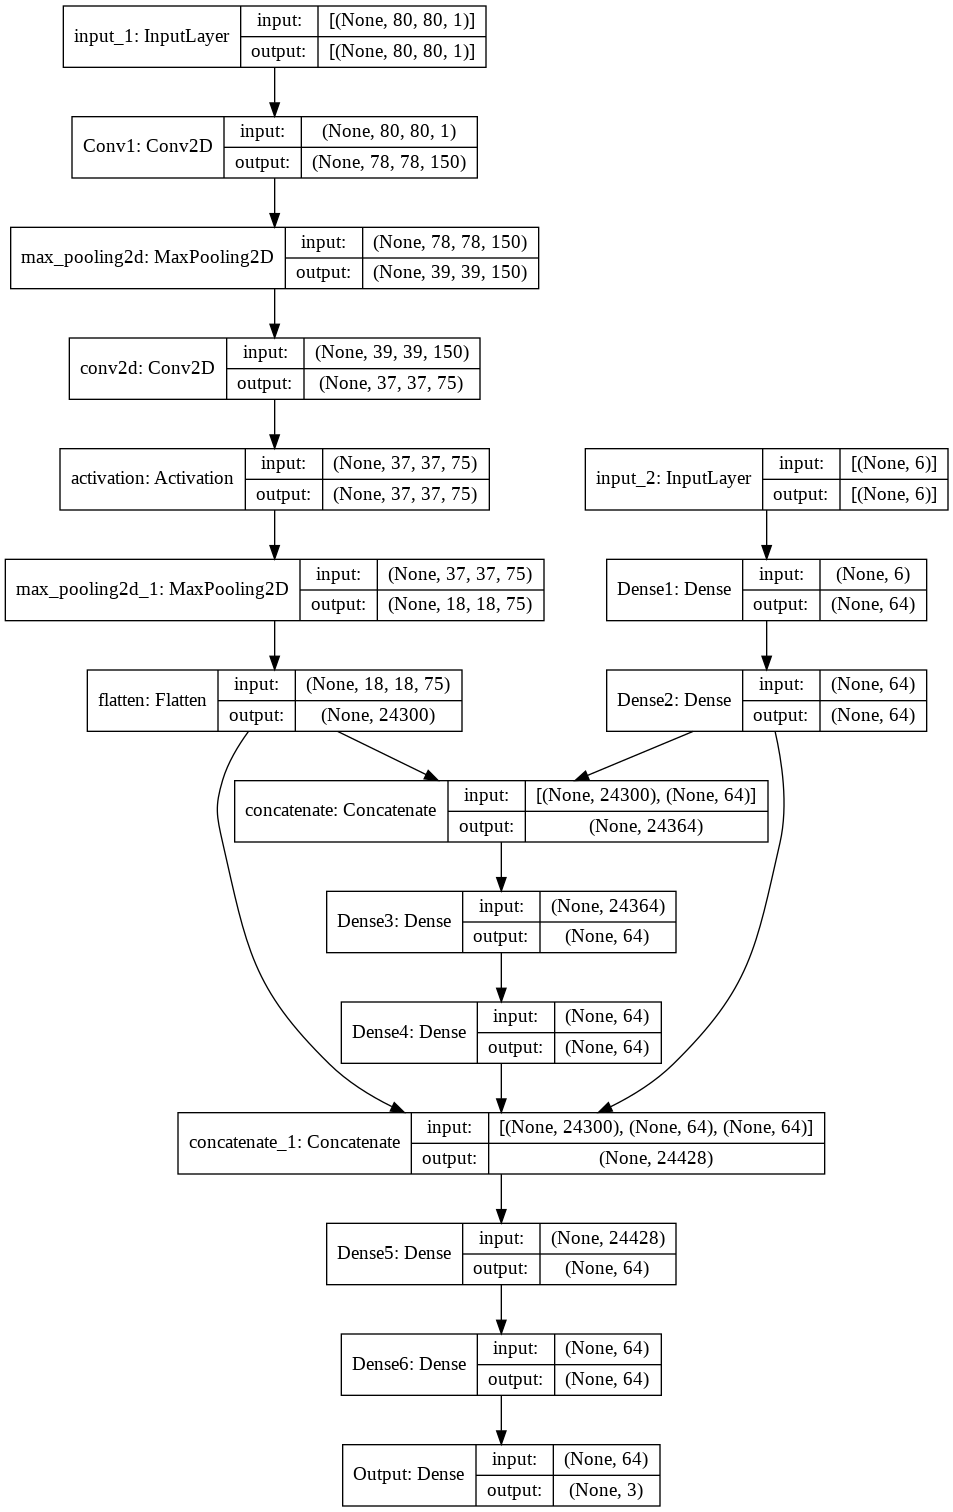

In [ ]:
tf.keras.utils.plot_model(model_CNN, show_shapes=True)

In [ ]:
filepath="best_model_L.h5-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_f1_score',  verbose=1, save_best_only=True, mode='auto')
model_CNN.fit([X_Data_tr,X_tr_hstack.todense()], Y_train,validation_data=([X_Data_cv,X_cr_hstack.todense()],Y_c), batch_size=32, epochs=3, validation_split=0.3,callbacks=checkpoint)

Epoch 1/3
219/219 [==============================] - 14s 27ms/step - loss: 0.4856 - accuracy: 0.8508 - f1_score: 0.4467 - val_loss: 0.0377 - val_accuracy: 0.9890 - val_f1_score: 0.4997

Epoch 00001: val_f1_score improved from inf to 0.49975, saving model to best_model_L.h5-01-0.99.hdf5
Epoch 2/3
219/219 [==============================] - 5s 23ms/step - loss: 0.0224 - accuracy: 0.9940 - f1_score: 0.4999 - val_loss: 0.0147 - val_accuracy: 0.9957 - val_f1_score: 0.5000

Epoch 00002: val_f1_score did not improve from 0.49975
Epoch 3/3
219/219 [==============================] - 5s 23ms/step - loss: 0.0058 - accuracy: 0.9990 - f1_score: 0.5000 - val_loss: 0.0128 - val_accuracy: 0.9980 - val_f1_score: 0.5000

Epoch 00003: val_f1_score did not improve from 0.49975


In [ ]:
def prepare(filepath):
    training_date = []
    img_array = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(80,80))
    new_image =  new_array.reshape(-1,80,80,1)
    return new_image

0it [00:00, ?it/s]

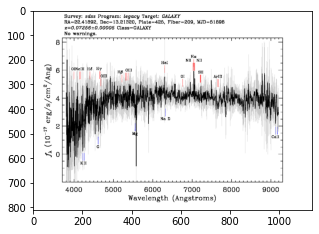

1it [00:00,  4.17it/s]

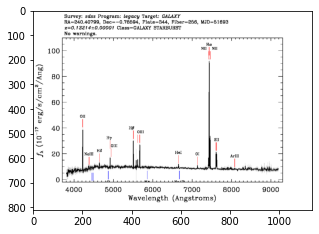

2it [00:00,  4.18it/s]

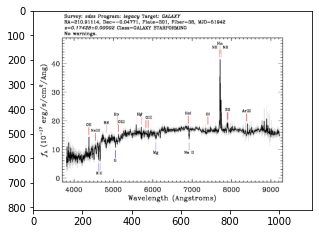

3it [00:00,  4.21it/s]

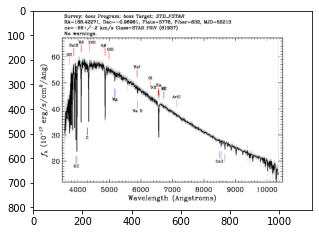

4it [00:00,  4.21it/s]

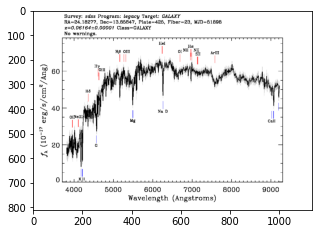

5it [00:01,  4.19it/s]

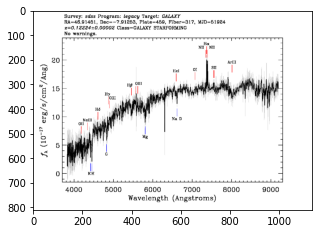

6it [00:01,  4.11it/s]

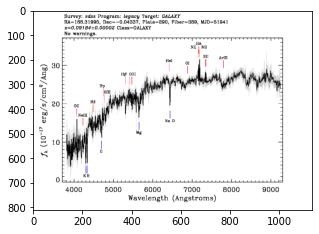

7it [00:01,  4.18it/s]

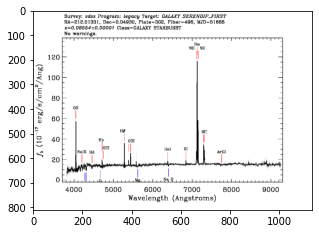

8it [00:01,  4.19it/s]

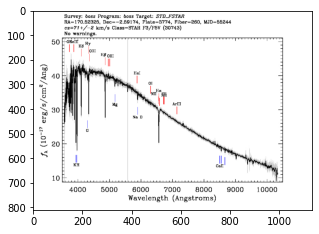

9it [00:02,  4.17it/s]

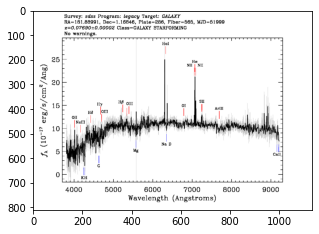

10it [00:02,  4.19it/s]


In [ ]:
for j,i in tqdm(enumerate(list(y_test.index)[:10])):
  filepath = X_test.loc[[i]].img_path.values[0]
  img_array = cv2.imread(filepath)
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1, 1, 1)
  plt.imshow(img_array)
  plt.show()

In [ ]:
y_pred_img=[]
for x,i in enumerate(list(y_test.index)):
    #CATERGORIES = {1:'QSO',0:'GALAXY',2:'STAR'}
    filepath=X_test.loc[[i]].img_path.values[0]
    test = model_CNN.predict([prepare(filepath=filepath),X_te_hstack.todense()[x]])
    predicted_class =np.argmax(test, axis=-1)
    y_pred_img.append(predicted_class[0])

# Combining the final results

final prediction using cnn model on image features




In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,y_pred_img, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       1.00      1.00      1.00      2272
       QSO:1       0.99      1.00      0.99       428
      STAR:2       1.00      1.00      1.00      2280

    accuracy                           1.00      4980
   macro avg       1.00      1.00      1.00      4980
weighted avg       1.00      1.00      1.00      4980



In [ ]:
[[tn1, fp1], [fn1, tp1]]=multilabel_confusion_matrix(y_test,y_pred_img)[1]

final prediction using knn base model+  cnn model on image features

In [ ]:
final_pred_on_knn = []
for i in range(len(y_pred_img)):
    if list(y_pred_img)[i] == 1.0 or list(y_pred_test_knn_cos)[i]==1.0:
      final_pred_on_knn.append(1.0)
    else:
      final_pred_on_knn.append(list(y_pred_img)[i])

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,final_pred_on_knn, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       1.00      0.97      0.98      2272
       QSO:1       0.86      1.00      0.92       428
      STAR:2       1.00      1.00      1.00      2280

    accuracy                           0.98      4980
   macro avg       0.95      0.99      0.97      4980
weighted avg       0.99      0.98      0.99      4980



In [ ]:
[[tn2, fp2], [fn2, tp2]] = multilabel_confusion_matrix(y_test, final_pred_on_knn, labels=[0.0,1.0,2.0])[1]

final prediction using adaboost trained on misclassified points of knn base model+image_features

In [ ]:
y_pred_test_adaboost_on_img = ad_knn.predict(X_te_hstack)
final_pred3 = []
for i in range(len(y_pred_img)):
    if list(y_pred_img)[i] == 1.0 or list(y_pred_test_adaboost_on_img)[i]==1.0:
      final_pred3.append(1.0)
    else:
      final_pred3.append(list(y_pred_img)[i])

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test,final_pred3, target_names=label))


Classification Report

              precision    recall  f1-score   support

    GALAXY:0       1.00      0.75      0.86      2272
       QSO:1       0.43      1.00      0.60       428
      STAR:2       1.00      1.00      1.00      2280

    accuracy                           0.89      4980
   macro avg       0.81      0.92      0.82      4980
weighted avg       0.95      0.89      0.90      4980



In [ ]:
[[tn3, fp3], [fn3, tp3]]=multilabel_confusion_matrix(y_test, final_pred3, labels=[0.0,1.0,2.0])[1]

#First cut Approach:
---
1. CNN model.
---
1. KNN cosine is the base model.
2. Trained CNN model.
3. Combine the prediction of knn_cos with the predications of CNN model.
---
1. KNN cosine is the base model.
2. Took the misclassified points from knn cos model and trained ADABoost.
3. Trained CNN model.
4. Combine the prediction of AdaBoost with the predications of CNN model.




Model which performed best is knn base model with CNN with overall f1_score=0.97 and FN for QSO=2




In [ ]:
from sklearn.metrics import f1_score
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Overall_f1","TN_QSO", "FP_QSO","FN_QSO", "TP_QSO"]
x.add_rows(
    [
        ["final prediction using cnn model on image features",\
         round(f1_score(y_test,y_pred_img,average='weighted'),2),tn1, fp1,fn1, tp1],\
     
        ["final prediction using knn base model+  cnn model on image features", \
         round(f1_score(y_test,final_pred_on_knn,average='weighted'),2),tn2, fp2,fn2, tp2],\
        
        ["final prediction using adaboost trained on misclassified points of knn base model+image_features", \
         round(f1_score(y_test,final_pred3,average='weighted'),2),tn3, fp3,fn3, tp3],\
        
    ]
)
print(x)

+--------------------------------------------------------------------------------------------------+------------+--------+--------+--------+--------+
|                                              Model                                               | Overall_f1 | TN_QSO | FP_QSO | FN_QSO | TP_QSO |
+--------------------------------------------------------------------------------------------------+------------+--------+--------+--------+--------+
|                        final prediction using cnn model on image features                        |    1.0     |  4547  |   5    |   1    |  427   |
|               final prediction using knn base model+  cnn model on image features                |    0.99    |  4483  |   69   |   1    |  427   |
| final prediction using adaboost trained on misclassified points of knn base model+image_features |    0.9     |  3991  |  561   |   1    |  427   |
+--------------------------------------------------------------------------------------------------+

================================================================
# Stacking Classifier
================================================================


In [ ]:
X_tr1 = X_tr
X_c1 = X_c
X_test1 = X_test
y_tr1 = y_tr
y_test1 = y_test
y_c1 = y_c

## Random Sampling of rows and columns with replacement

In [ ]:
import random
import numpy as np
def generating_samples(input_data, target_data):
    selecting_rows=np.sort(np.random.choice(list(input_data.index),size=int((60/100)*len(input_data)),replace=False))
    replacing_rows=np.sort(np.random.choice(list(selecting_rows),size=len(selecting_rows)-100,replace=False))
    selecting_columns=np.sort(np.random.choice(input_data.shape[1],size=random.randint(3,6),replace=False))
    sample_data=input_data.loc[list(selecting_rows),input_data.columns[selecting_columns]]
    target_of_sample_data=target_data.loc[list(selecting_rows)]
    Replicated_sample_data=[]
    Replicated_sample_data=sample_data.loc[list(replacing_rows)]
    target_of_replicated_sample_data=[]
    target_of_replicated_sample_data=target_of_sample_data.loc[list(replacing_rows)]
    final_sample_data=pd.concat([sample_data,Replicated_sample_data])
    final_target_data=pd.concat([target_of_sample_data,target_of_replicated_sample_data])
    return final_sample_data , final_target_data,selecting_rows, input_data.columns[selecting_columns]

In [ ]:
#From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).
list_input_data =[]
list_output_data =[]
list_selected_row= []
list_selected_columns=[]
for i in range(8):
  a,b,c,d=generating_samples(X_tr1.drop('img_path',axis=1),pd.DataFrame(y_tr1))
  list_input_data.append(a)
  list_output_data.append(b)
  list_selected_row.append(c)
  list_selected_columns.append(d)

## 8 base models

In [ ]:
clf = [XGBClassifier(max_depth=10,probability=True),DecisionTreeClassifier(max_depth=5),svm.SVC(kernel='linear',C=8,probability=True),KNeighborsClassifier(n_neighbors=14, weights='distance', metric='cosine'),svm.SVC(kernel='rbf',C=8,probability=True), LogisticRegression(), GaussianNB(),AdaBoostClassifier()]

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import normalize
#Now create 'k' models and train each of these models with each of these k samples.
model=[]
sample_data={};target_data={}
for i in tqdm(range(8)):
    clf[i].fit(normalize(list_input_data[i]),np.ravel(list_output_data[i]))
    model.append(clf[i])

 62%|██████▎   | 5/8 [00:47<00:21,  7.17s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|██████████| 8/8 [00:48<00:00,  6.07s/it]


In [ ]:
with open("list_selected_columns.txt", "wb") as fp:   #Pickling
  pickle.dump(list_selected_columns, fp)

In [ ]:
#Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models
predictions_d2=[]
predictions_test=[]
for i in tqdm(range(8)):
    pkl.dump(model[i], open(str(i)+'.pkl', 'wb'))    
    predictions_d2.append(model[i].predict_proba(normalize(X_c1[list_selected_columns[i]])))
    predictions_test.append(model[i].predict_proba(normalize(X_test1[list_selected_columns[i]])))

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


In [ ]:
dic={};dic_test={}
for j in range(8):
  dic[j] = model[j].predict(normalize(X_c1[list_selected_columns[j]]))
  dic_test[j] = model[j].predict(normalize(X_test1[list_selected_columns[j]]))

In [ ]:
data_for_metamodel=pd.DataFrame.from_dict(dic)
data_for_test_metamodel=pd.DataFrame.from_dict(dic_test)

In [ ]:
data_for_metamodel

,0,1,2,3,4,5,6,7
0,2.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
1,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0
2,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0
3,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
4,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...
4925,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0
4926,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
4927,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
4928,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
data_for_test_metamodel

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0
2,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
4975,2.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
4976,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4977,1.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0
4978,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0


In [ ]:
Conv1_layer=Conv2D(150, (3, 3),activation='relu',input_shape=X_Data_cv.shape[1:],name='Conv1')(input)
Max_pool1=MaxPooling2D(pool_size=(2, 2))(Conv1_layer)
Conv2_layer=Conv2D(75, (3, 3))(Max_pool1)
Act2=Activation('relu')(Conv2_layer)
Max_pool2=MaxPooling2D(pool_size=(2, 2))(Act2)
flatten1=Flatten()(Max_pool2)
Dense3=Dense(1000,name='Dense3')(flatten1)
Dense4=Dense(256,name='Dense4')(Dense3)
Dense5=Dense(64,name='Dense5')(Dense4)
model2 = Model(inputs=input,outputs=Dense5)

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 78, 150)       1500      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 150)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 75)        101325    
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 75)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 75)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24300)             0   

In [ ]:
model2.save('model2')

INFO:tensorflow:Assets written to: model2/assets


In [ ]:
output=model2.predict([X_Data_cv])

In [ ]:
output.shape,data_for_metamodel.shape

((4930, 64), (4930, 8))

In [ ]:
final=np.concatenate((output,data_for_metamodel),axis=1)

In [ ]:
output_test = model2.predict([X_Data_test])

In [ ]:
final_test=np.concatenate((output_test,data_for_test_metamodel),axis=1)

## Metamodel 

In [ ]:
#Now, using these k predictions, create a new dataset, and for D2, you already 
#know it's corresponding target values, so now you train a metamodel with these k predictions.
xgb=XGBClassifier(verbosity=1)
xgb.fit(final,y_c1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
pkl.dump(xgb, open('xgb.sav', 'wb'))

In [ ]:
# Now, for model evaluation, you have can use the 20% data that you have kept as the test set. 
#Pass that test set to each of the base models, and you will get 'k' predictions. 
#Now you create a new dataset with these k predictions and pass it to your metamodel, 
#and you will get the final prediction. Using this final prediction and the targets for the test set,
#you can calculate the model's performance score.
y_pred_test_xgb1=xgb.predict(final_test)

## Calibration on metamodel results

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_meta = CalibratedClassifierCV(base_estimator=xgb,method='isotonic',cv=5)
calibrated_meta.fit(final, y_c1)
calibrated_meta =calibrated_meta.predict_proba(final_test)

In [ ]:
y_calib1=[]
for i in calibrated_meta:
  if i[1] > 0.5:
    y_calib1.append(1)
  else:
    y_calib1.append(np.argmax(i))

## Results Without Calibration on probabilities predicted by metamodel

In [ ]:
multilabel_confusion_matrix(y_test1,y_pred_test_xgb1,labels=[0.0,1.0,2.0])

array([[[2664,   44],
        [  15, 2257]],

       [[4540,   12],
        [  39,  389]],

       [[2696,    4],
        [   6, 2274]]])

## Results With Calibration on probabilities predicted by metamodel

In [ ]:
multilabel_confusion_matrix(y_test1,y_calib1,labels=[0.0,1.0,2.0])

array([[[2668,   40],
        [  18, 2254]],

       [[4537,   15],
        [  35,  393]],

       [[2696,    4],
        [   6, 2274]]])

## Calibration on base models

In [ ]:
y_calib_all=[]
for j in range(len(predictions_d2)):
  y_calib=[]
  for i in predictions_d2[j]:
    if i[1] > 0.1:
      y_calib.append(1)
    else:
      y_calib.append(np.argmax(i))
  y_calib_all.append(y_calib)

In [ ]:
len(predictions_d2[j])

4930

In [ ]:
y_calib_all_test=[]
for j in range(len(predictions_test)):
  y_calib=[]
  for i in predictions_test[j]:
    if i[1] > 0.1:
      y_calib.append(1)
    else:
      y_calib.append(np.argmax(i))
  y_calib_all_test.append(y_calib)

In [ ]:
np.array(y_calib_all_test).shape

(8, 4980)

In [ ]:
f = pd.DataFrame(list(np.array(y_calib_all).reshape(4930,8)), columns = range(0,8))  

In [ ]:
f_test = pd.DataFrame(list(np.array(y_calib_all_test).reshape(4980,8)), columns = range(0,8))  

In [ ]:
final_calib=np.concatenate((output,f),axis=1)
final_test_calib=np.concatenate((output_test,f_test),axis=1)

In [ ]:
#Now, using these k predictions, create a new dataset, and for D2, you already 
#know it's corresponding target values, so now you train a metamodel with these k predictions.
xgb=XGBClassifier(verbosity=1)
xgb.fit(final_calib,y_c1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
calibrated_meta_on_base = CalibratedClassifierCV(base_estimator=xgb,method='isotonic',cv=5)
calibrated_meta_on_base.fit(final_calib, y_c1)
calibrated_on_base =calibrated_meta_on_base.predict_proba(final_test_calib)

In [ ]:
y_calib_base=[]
for i in calibrated_on_base:
  if i[1] > 0.5:
    y_calib_base.append(1)
  else:
    y_calib_base.append(np.argmax(i))

In [ ]:
multilabel_confusion_matrix(y_test1,y_calib_base,labels=[0.0,1.0,2.0])

array([[[2560,  148],
        [  85, 2187]],

       [[4462,   90],
        [ 132,  296]],

       [[2626,   74],
        [  95, 2185]]])

## How each base model in stacking classifier working

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-1], labels=[0.0,1.0,2.0])

array([[[2707,    1],
        [2096,  176]],

       [[2476, 2076],
        [   1,  427]],

       [[2679,   21],
        [   1, 2279]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-2], labels=[0.0,1.0,2.0])

array([[[2614,   94],
        [ 144, 2128]],

       [[4430,  122],
        [  77,  351]],

       [[2676,   24],
        [  19, 2261]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-3], labels=[0.0,1.0,2.0])

array([[[2637,   71],
        [2225,   47]],

       [[3772,  780],
        [ 287,  141]],

       [[ 686, 2014],
        [ 353, 1927]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-4], labels=[0.0,1.0,2.0])

array([[[2563,  145],
        [1804,  468]],

       [[3580,  972],
        [   8,  420]],

       [[1865,  835],
        [ 140, 2140]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-5], labels=[0.0,1.0,2.0])

array([[[1785,  923],
        [1408,  864]],

       [[3235, 1317],
        [ 325,  103]],

       [[1821,  879],
        [1386,  894]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-6], labels=[0.0,1.0,2.0])

array([[[2338,  370],
        [1715,  557]],

       [[3855,  697],
        [  12,  416]],

       [[1675, 1025],
        [ 365, 1915]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-7], labels=[0.0,1.0,2.0])

array([[[2672,   36],
        [  70, 2202]],

       [[4497,   55],
        [  31,  397]],

       [[2684,   16],
        [   6, 2274]]])

In [ ]:
multilabel_confusion_matrix(y_test1.values, y_calib_all_test[-8], labels=[0.0,1.0,2.0])

array([[[2667,   41],
        [  39, 2233]],

       [[4516,   36],
        [  35,  393]],

       [[2696,    4],
        [   7, 2273]]])

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test1,y_calib_all_test[-1], target_names=['GALAXY','QSO','STAR']))


Classification Report

              precision    recall  f1-score   support

      GALAXY       0.99      0.08      0.14      2272
         QSO       0.17      1.00      0.29       428
        STAR       0.99      1.00      1.00      2280

    accuracy                           0.58      4980
   macro avg       0.72      0.69      0.48      4980
weighted avg       0.92      0.58      0.55      4980



## Tried Adaboost and SVM but was not giving good results

In [ ]:
#Now, using these k predictions, create a new dataset, and for D2, you already 
#know it's corresponding target values, so now you train a metamodel with these k predictions.
adb=AdaBoostClassifier()
adb.fit(final,y_c1)

In [ ]:
y_pred_test_adb = adb.predict(final_test)
multilabel_confusion_matrix(y_test1.values, y_pred_test_adb, labels=[0.0,1.0,2.0])

In [ ]:
#Now, using these k predictions, create a new dataset, and for D2, you already 
#know it's corresponding target values, so now you train a metamodel with these k predictions.
SVM=svm.SVC(kernel='linear')
SVM.fit(final,y_c1)
y_pred_test_svm = SVM.predict(final_test)
multilabel_confusion_matrix(y_test1.values, y_pred_test_svm, labels=[0.0,1.0,2.0])

## Conclusion
The results where good when
XGB classifiers was used as the meta model in stacking classifier after probability calibration. 

======================================================
#BINARY CLASSIFICATION
======================================================
# PARTEN Approach

In [ ]:
y_tr2 = pd.DataFrame(data=np.where(y_tr.values==1.0,1,0),columns=['cl_label'],index=y_tr.index)
X_tr2 = X_tr.copy()
y_c2 = pd.DataFrame(data=np.where(y_c.values==1.0,1,0),columns=['cl_label'],index=y_c.index)
X_c2 = X_c.copy()
y_test2 = pd.DataFrame(data=np.where(y_test.values==1.0,1,0),columns=['cl_label'],index=y_test.index)
X_test2 = X_test.copy()

In [ ]:
X_tr2 = pd.concat([X_tr2,X_c2])
y_tr2 = pd.concat([y_tr2,y_c2])

In [ ]:
## Creating the image data for train data for class NON QSO
!rm -rf 'X_Data'
!rm -rf 'Y_Data'
y_df1 = y_tr2[y_tr2["cl_label"]!= 1.0]
df1 = X_tr2.loc[list(y_df1.index)]
a = MasterImage(PATH=list(df1.img_path.values),y_cl=list(y_df1['cl_label'].values),IMAGE_SIZE=80)
X_Data_df1,Y_Data_df1 = a.load_dataset()
input=Input(X_Data_df1.shape[1:])
df1 = df1.drop(['img_path'],axis=1)

Could not Found Pickle File 
Loading File and Dataset  ..........


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Pickled Image Successfully 


In [ ]:
Counter(y_df1['cl_label'].values)

Counter({0: 13656})

In [ ]:
## Creating the image data for train data for QSO.
!rm -rf 'X_Data'
!rm -rf 'Y_Data'

y_df2 = y_tr2[y_tr2["cl_label"]== 1.0]
df2 = X_tr2.loc[list(y_df2.index)]
a = MasterImage(PATH=list(df2.img_path.values),y_cl=list(y_df2['cl_label'].values),IMAGE_SIZE=80)
X_Data_df2,Y_Data_df2 = a.load_dataset()
input=Input(X_Data_df2.shape[1:])
df2 = df2.drop(['img_path'],axis=1)

Could not Found Pickle File 
Loading File and Dataset  ..........
Pickled Image Successfully 


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
Counter(y_df2['cl_label'].values)

Counter({1: 1282})

In [ ]:
## Creating the image data for test data.

!rm -rf 'X_Data'
!rm -rf 'Y_Data'

y_test_df = pd.DataFrame(y_test2["cl_label"].values,columns=['cl_label'],index=list(y_test2["cl_label"].index))
df_test = X_test2.copy()

a = MasterImage(PATH=list(df_test.img_path.values),y_cl=list(y_test_df['cl_label'].values),IMAGE_SIZE=80)
X_Data_test_df,Y_Data_test_df = a.load_dataset()
input=Input(X_Data_test_df.shape[1:])

df_test = df_test.drop(['img_path'],axis=1)

Could not Found Pickle File 
Loading File and Dataset  ..........


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Pickled Image Successfully 


In [ ]:
Conv1_layer=Conv2D(150, (3, 3),activation='relu',input_shape=X_Data_df2.shape[1:],name='Conv1')(input)
Max_pool1=MaxPooling2D(pool_size=(2, 2))(Conv1_layer)
Conv2_layer=Conv2D(75, (3, 3))(Max_pool1)
Act2=Activation('relu')(Conv2_layer)
Max_pool2=MaxPooling2D(pool_size=(2, 2))(Act2)
flatten1=Flatten()(Max_pool2)
Dense3=Dense(1000,name='Dense3')(flatten1)
Dense4=Dense(256,name='Dense4')(Dense3)
Dense5=Dense(64,name='Dense5')(Dense4)
model3 = Model(inputs=input,outputs=Dense5)

In [ ]:
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 78, 150)       1500      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 39, 150)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 75)        101325    
_________________________________________________________________
activation_2 (Activation)    (None, 37, 37, 75)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 75)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 24300)             0   

In [ ]:
## Taking image embeddings
output=model3.predict([X_Data_df1]) ## train for QSO
output_2 = model3.predict([X_Data_df2]) ## train for NON QSO
output_test = model3.predict([X_Data_test_df]) ## test 

In [ ]:
img_feat_df1 = pd.DataFrame(output,columns = range(output.shape[1]),index=df1.index) ## creating img train data for QSO(minority)
img_feat_df2 = pd.DataFrame(output_2,columns = range(output_2.shape[1]),index=df2.index) ## creating img train data for QSO(majority)
img_feat_test_df = pd.DataFrame(output_test,columns = range(output_test.shape[1]),index=df_test.index) ## creating img test data

In [ ]:
## Generating Samples
import random
import numpy as np
def generating_samples(input_data, target_data,img_feat_df1):
    
    selecting_rows=np.sort(np.random.choice(list(input_data.index),size=int((50/100)*len(input_data)),replace=False))
    replacing_rows=np.sort(np.random.choice(list(selecting_rows),size=len(selecting_rows)-100,replace=False))
    
    sample_data=input_data.loc[list(selecting_rows)] ## Row sampling on numerical feat
    img_feat_df1=img_feat_df1.loc[list(selecting_rows)] ## Row sampling on img embedding feat
    target_of_sample_data=target_data.loc[list(selecting_rows)]
    
    Replicated_sample_data=[]
    Replicated_sample_data=sample_data.loc[list(replacing_rows)]
    Replicated_img_data=img_feat_df1.loc[list(replacing_rows)]
    target_of_replicated_sample_data=[]
    target_of_replicated_sample_data=target_of_sample_data.loc[list(replacing_rows)]
    
    final_sample_data=pd.concat([sample_data,Replicated_sample_data])
    final_img_data = pd.concat([img_feat_df1,Replicated_img_data])
    final_target_data=pd.concat([target_of_sample_data,target_of_replicated_sample_data])
    
    ## return final sampled data(majority class),selected rows, target data
    return  pd.concat([final_sample_data,final_img_data],axis=1) ,final_target_data,selecting_rows 

In [ ]:
#From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).
list_input_data =[]
list_output_data =[]
list_selected_row= []
for i in range(8):
  a,b,c=generating_samples(df1,y_df1,img_feat_df1)
  min_data = pd.concat([df2,img_feat_df2],axis=1) ## concatenate the minority class numerical feat with image embeddings of minority class data
  a = pd.concat([a,min_data], axis = 0, join = 'inner') ## concatenate the majority class samples with the entire minority class data
  b = pd.concat([b,pd.DataFrame(y_df2)], axis = 0, join = 'inner') 
  list_input_data.append(a)
  list_output_data.append(b)

In [ ]:
Counter(list_output_data[0]['cl_label'].values)

Counter({0: 13556, 1: 1282})

In [ ]:
from sklearn.utils import shuffle
input_data=[];output_data=[]
for i in range(8):
  X, y = shuffle(list_input_data[0], list_output_data[0]) ## shuffle the data
  input_data.append(X)
  output_data.append(y) ## k samples are created

In [ ]:
clf = [XGBClassifier(),DecisionTreeClassifier(),svm.SVC(kernel='linear',probability=True),KNeighborsClassifier(),svm.SVC(), LogisticRegression(), GaussianNB(),AdaBoostClassifier()]

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score
#Now create 'k' models and train each of these models with each of these k samples.
model=[]
sample_data={};target_data={};param=[{'max_depth':[5,10,100,500]},{'max_depth':[5,10,100,500]},{'C':[4,8,10,20,50,100]},
                                     {'n_neighbors':[4,8,12,20,30]},{'gamma':[0.0001,0.001,0.01,2,5,10],'C':[4,8,10,20,50,100]},
                                      {'C':[0.001,0.01,0.1,1,10,100]},{'var_smoothing': np.logspace(0,-5, num=100)},
                                     {'n_estimators': [100,200,300]}]
p=[]
for i in tqdm(range(8)):
    m = GridSearchCV(clf[i], param[i],n_jobs=-1, cv=3, verbose=10,scoring='roc_auc',return_train_score=True)
    m.fit(normalize(input_data[i]),np.ravel(output_data[i]))
    p.append(list(m.best_params_.values()))

  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished
 12%|█▎        | 1/8 [01:22<09:34, 82.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.1s finished
 25%|██▌       | 2/8 [01:28<05:56, 59.48s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.7min finished
 38%|███▊      | 3/8 [04:39<08:13, 98.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.9s finished
 50%|█████     | 4/8 [04:55<04:55, 73.97s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.1min finished
 62%|██████▎   | 5/8 [10:03<07:12, 144.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1699s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 75%|███████▌  | 6/8 [10:05<03:23, 101.54s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0673s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1573s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished
 88%|████████▊ | 7/8 [10:13<01:13, 73.50s/it] 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.4min remaining:   24.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.9min finished
100%|██████████| 8/8 [12:19<00:00, 92.38s/it]


In [ ]:
p

[[5], [5], [20], [30], [10, 2], [100], [1e-05], [100]]

In [ ]:
clf_final = [XGBClassifier(max_depth=p[0][0],probability=True),DecisionTreeClassifier(max_depth=p[1][0]),svm.SVC(kernel='linear',C=p[2][0],probability=True),KNeighborsClassifier(n_neighbors=p[3][0], weights='distance', metric='cosine'),svm.SVC(kernel='rbf',C=p[4][1],gamma=p[4][0],probability=True), LogisticRegression(C=p[5][0]), GaussianNB(var_smoothing=p[6][0]),AdaBoostClassifier(n_estimators=p[7][0])]

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score
#Now create 'k' models and train each of these models with each of these k samples.
model_final=[]
for i in tqdm(range(8)):
    clf_final[i].fit(normalize(input_data[i]),np.ravel(output_data[i]))
    model_final.append(clf_final[i])
    pkl.dump(clf_final[i], open(str(i)+'parten.sav', 'wb'))

 62%|██████▎   | 5/8 [01:08<00:48, 16.31s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|██████████| 8/8 [01:20<00:00, 10.05s/it]


In [ ]:
test_data = pd.concat([df_test,img_feat_test_df],axis=1)
dic_test={}
for j in range(8):
   dic_test[j] = model_final[j].predict(normalize(test_data)) ## take all the predictions

In [ ]:
pred_data_test = pd.DataFrame.from_dict(dic_test) ## create a dataframe 

In [ ]:
pred_test_parten=[]
for i in range(test_data.shape[0]):
  pred_test_parten.append(max(Counter(pred_data_test.loc[i].values),key=Counter(pred_data_test.loc[i].values).get)) ## take the majority vote as the final class 

In [ ]:
confusion_matrix(list(y_test_df['cl_label'].values),pred_test_parten)

array([[4547,    5],
       [  72,  356]])

In [ ]:
from sklearn.metrics import f1_score
r1 = recall_score(list(y_test_df['cl_label'].values),pred_test_parten)
r1

0.8317757009345794

In [ ]:
f1_score1 = f1_score(list(y_test_df['cl_label'].values),pred_test_parten)
f1_score1

0.9024081115335868

# Majority vote:

In [ ]:
y_pred_test_x = np.where(np.array(y_pred_test_xgboost)==1.0,1.0,0) ## xgboost
y_pred_i=np.where(np.array(y_pred_img)==1.0,1.0,0) ## cnn model
final_pred_on_k=np.where(np.array(final_pred_on_knn)==1.0,1.0,0) ## custom classifier
y_calib_b = np.where(np.array(y_pred_test_xgb1)==1.0,1.0,0) ## stacking classifier

In [ ]:
#pred_test_parten ## parten approach

In [ ]:
## Took the majority vote of all the models including parten approach(binary class classification)
final_vote=[]
for i in range(4980): ## majority vote
  final_vote.append(max(Counter(np.array((y_pred_test_x[i],pred_test_parten[i],y_pred_i[i],final_pred_on_k[i],y_calib_b[i]))),key=Counter(np.array((y_pred_test_x[i],pred_test_parten[i],y_pred_i[i],final_pred_on_k[i],y_calib_b[i]))).get))

In [ ]:
## Took the majority vote of CNN and stacking models to separate the non qso points into stars and galaxies
pred=[]
for i,y in enumerate(final_vote):
  if y != 1.0:
    pred.append(max(Counter(np.array((y_pred_img[i],y_pred_test_xgb1[i]))),key=Counter(np.array((y_pred_img[i],y_pred_test_xgb1[i]))).get))
  else:
    pred.append(y)

In [ ]:
multilabel_confusion_matrix(list(y_test.values),list(pred))

array([[[2705,    3],
        [  14, 2258]],

       [[4538,   14],
        [   1,  427]],

       [[2696,    4],
        [   6, 2274]]])

#Final Results

In [ ]:
from sklearn.metrics import f1_score
f1_score_maj = f1_score(list(y_test.values),list(map(int,y_pred_test_xgboost)),average='weighted')
r1_score_maj = recall_score(list(y_test.values),list(map(int,y_pred_test_xgboost)),average='micro')
[[tn1, fp1],[fn1, tp1]] =multilabel_confusion_matrix(list(y_test.values),list(map(int,y_pred_test_xgboost)))[1] 

f2_score_maj = f1_score(list(y_test.values),list(map(int,y_pred_img)),average='weighted')
r2_score_maj = recall_score(list(y_test.values),list(map(int,y_pred_img)),average='micro')
[[tn2, fp2],[fn2, tp2]] =multilabel_confusion_matrix(list(y_test.values),list(map(int,y_pred_img)))[1]

f3_score_maj = f1_score(list(y_test.values),list(map(int,final_pred_on_knn)),average='weighted')
r3_score_maj = recall_score(list(y_test.values),list(map(int,final_pred_on_knn)),average='micro')
[[tn3, fp3],[fn3, tp3]] =multilabel_confusion_matrix(list(y_test.values),list(map(int,final_pred_on_knn)))[1]


f4_score_maj = f1_score(list(y_test.values),list(map(int,y_pred_test_xgb1)),average='weighted')
r4_score_maj = recall_score(list(y_test.values),list(map(int,y_pred_test_xgb1)),average='micro')
[[tn4, fp4],[fn4, tp4]] =multilabel_confusion_matrix(list(y_test.values),list(map(int,y_pred_test_xgb1)))[1]

In [ ]:
f6_score_maj = f1_score(list(y_test.values),pred,average='weighted')
r6_score_maj = recall_score(list(y_test.values),pred,average='micro')
[[tn6, fp6],[fn6, tp6]] =multilabel_confusion_matrix(list(y_test.values),pred)[1] 


In [ ]:
from sklearn.metrics import f1_score
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "f1","Recall","TN_QSO", "FP_QSO","FN_QSO", "TP_QSO","NON_QSO_points","QSO_points"]
x.add_row(
        ["final prediction using xgboost model", \
         round(f1_score_maj,2),round(r1_score_maj,2),tn1, fp1,fn1, tp1,Counter(y_test_df['cl_label'].values)[0],Counter(y_test_df['cl_label'].values)[1]]
)
x.add_row(  
        ["final prediction using CNN model", \
         round(f2_score_maj,2),round(r2_score_maj,2),tn2, fp2,fn2, tp2,Counter(y_test_df['cl_label'].values)[0],Counter(y_test_df['cl_label'].values)[1]]
)
x.add_row(
        ["final prediction using custom ensemble classifier", \
         round(f3_score_maj,2),round(r3_score_maj,2),tn3, fp3,fn3, tp3,Counter(y_test_df['cl_label'].values)[0],Counter(y_test_df['cl_label'].values)[1]]
)
x.add_row(
        ["final prediction using stacking classifier", \
         round(f4_score_maj,2),round(r4_score_maj,2),tn4, fp4,fn4, tp4,Counter(y_test_df['cl_label'].values)[0],Counter(y_test_df['cl_label'].values)[1]]
)
x.add_row(
        ["final prediction using majority vote for all models",\
         round(f6_score_maj,2),round(r6_score_maj,2),tn6, fp6,fn6, tp6,Counter(y_test_df['cl_label'].values)[0],Counter(y_test_df['cl_label'].values)[1]]          
)
print(x)

+-----------------------------------------------------+------+--------+--------+--------+--------+--------+----------------+------------+
|                        Model                        |  f1  | Recall | TN_QSO | FP_QSO | FN_QSO | TP_QSO | NON_QSO_points | QSO_points |
+-----------------------------------------------------+------+--------+--------+--------+--------+--------+----------------+------------+
|         final prediction using xgboost model        | 0.81 |  0.78  |  3487  |  1065  |   6    |  422   |      4552      |    428     |
|           final prediction using CNN model          | 1.0  |  1.0   |  4547  |   5    |   1    |  427   |      4552      |    428     |
|  final prediction using custom ensemble classifier  | 0.99 |  0.98  |  4483  |   69   |   1    |  427   |      4552      |    428     |
|      final prediction using stacking classifier     | 0.99 |  0.99  |  4540  |   12   |   39   |  389   |      4552      |    428     |
| final prediction using majority 

# Final pipeline

In [ ]:
import pickle
## https://github.com/soumilshah1995/Smart-Library-to-load-image-Dataset-for-Convolution-Neural-Network-Tensorflow-Keras-/blob/master/masterimage.py
class MasterI(object):
    def __init__(self,PATH='', IMAGE_SIZE = 50):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE
        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.class_index = []
        self.img_paths = []
        self.list_categories = []
    
    def Process_Image(self):
            img_paths = self.PATH
            for img in img_paths:
              image_data_temp = cv2.imread(img,cv2.IMREAD_GRAYSCALE)                 
              image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
              self.image_data.append([image_temp_resize])
            data = np.asanyarray(self.image_data)

            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
            X_Data = np.asarray(self.x_data) / (255.0)      # Normalize Data
            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)
            return X_Data
        
    def pickle_image(self):

        X_Data = self.Process_Image()
        pickle_out = open('X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()        
        print("Pickled Image Successfully ")
        return X_Data

    def load_dataset(self):

        try:
            X_Temp = open('X_Data','rb')
            X_Data = pickle.load(X_Temp)
            print('Reading Dataset from PIckle Object')
            return X_Data
        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')
            X_Data = self.pickle_image()
            return X_Data

In [ ]:
from timeit import default_timer as timer
start = timer()
import warnings
warnings.filterwarnings("ignore")

def preprocess(X_test):

  with open('/content/normalizer_ra.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_ra_norm = normalizer.transform(X_test['ra'].values.reshape(1,-1)).reshape(-1,1)

  with open('/content/normalizer_dec.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_dec_norm = normalizer.transform(X_test['dec'].values.reshape(1,-1)).reshape(-1,1)
  
  
  with open('/content/normalizer_redshift.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_redshift_norm = normalizer.transform(X_test['redshift'].values.reshape(1,-1)).reshape(-1,1)
  
  with open('/content/normalizer_Dim_1.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_Dim_1_norm = normalizer.transform(X_test['Dim_1'].values.reshape(1,-1)).reshape(-1,1)
  
  with open('/content/normalizer_Dim_2.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_Dim_2_norm = normalizer.transform(X_test['Dim_2'].values.reshape(1,-1)).reshape(-1,1)
  
  with open('/content/normalizer_Dim_3.sav',"rb") as f:
    normalizer = pkl.load(f)
  X_test_Dim_3_norm = normalizer.transform(X_test['Dim_3'].values.reshape(1,-1)).reshape(-1,1)
  
  return hstack(( coo_matrix(X_test_ra_norm),X_test_dec_norm,X_test_redshift_norm,X_test_Dim_1_norm,X_test_Dim_2_norm,X_test_Dim_3_norm)).tocsr()

def prepare(filepath):
    training_date = []
    img_array = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(80,80))
    new_image =  new_array.reshape(-1,80,80,1)
    return new_image


def final_pipeline(datapoint):
  
  ##XGBOOST MODEL
  X_te_hstack = preprocess(datapoint.drop('img_path',axis=1))
  model_xgboost = pkl.load(open("/content/model_xgboost.sav", 'rb'))
  y_pred_test_xgboost = model_xgboost.predict(X_te_hstack)
  
  ##CNN MODEL
  model_CNN.load_weights("/content/best_model_L.h5-01-0.99.hdf5")
  y_pred_img=[]
  for x,i in enumerate(list(datapoint.index)):
    filepath=datapoint.loc[[i]].img_path.values[0]
    test = model_CNN.predict([prepare(filepath=filepath),X_te_hstack.todense()[x]])
    predicted_class =np.argmax(test, axis=-1)
    y_pred_img.append(predicted_class[0])#print(ped_img_point)

  ##COSTUM CLASSIFIER
  final_pred_on_knn = []
  model_knn_cosine = pkl.load(open("/content/model_knn_cosine.sav", 'rb'))
  y_pred_test_knn_cos = model_knn_cosine.predict(X_te_hstack) 
  for i in range(len(y_pred_img)):
    if list(y_pred_img)[i] == 1.0 or list(y_pred_test_knn_cos)[i]==1.0:
      final_pred_on_knn.append(1.0)
    else:
      final_pred_on_knn.append(list(y_pred_img)[i])

  ##STACKING CLASSIFIER
  dic_test={}
  for i in range(8):
    with open(str(i)+".pkl","rb") as f:
        x=pkl.load(f)
    with open("list_selected_columns.txt", "rb") as fp:   # Unpickling
          li = pickle.load(fp)
    dic_test[i] = x.predict(normalize(datapoint[list_selected_columns[i]]))
  
  reconstructed_model = keras.models.load_model("model2")
  !rm -rf 'X_Data'
  !rm -rf 'Y_Data'
  a = MasterI(PATH=list(datapoint.img_path.values),IMAGE_SIZE=80)
  X_Data_test = a.load_dataset()
  img_emb = reconstructed_model.predict([X_Data_test])
  xgb = pkl.load(open("/content/xgb.sav", 'rb'))
  pred_x = xgb.predict(np.concatenate((img_emb,pd.DataFrame.from_dict(dic_test)),axis=1))
  
  ##PARTEN APPROACH
  parten_data = pd.concat([datapoint.drop('img_path',axis=1),pd.DataFrame(img_emb,columns = range(img_emb.shape[1]),index=datapoint.index)],axis=1)
  dic_test1={}
  for j in range(8):
    clf = pkl.load(open(str(i)+'parten.sav', 'rb'))
    dic_test1[j] = clf.predict(normalize(parten_data)) ## take all the predictions

  pred_test_parten=[]
  for i in range(parten_data.shape[0]):
    pred_test_parten.append(max(Counter(pd.DataFrame.from_dict(dic_test1).loc[i].values),key=Counter(pd.DataFrame.from_dict(dic_test1).loc[i].values).get)) ## take the majority vote as the final class 
    
  ##FOR (binary class classification)
  pred_p = np.where(np.array(y_pred_test_xgboost)==1.0,1.0,0) ## xgboost
  ped_img_p=np.where(np.array(y_pred_img)==1.0,1.0,0) ## cnn model
  final_pred_on_k=np.where(np.array(final_pred_on_knn)==1.0,1.0,0) ## custom classifier
  pred_ = np.where(np.array(pred_x)==1.0,1.0,0) ## stacking classifier
  
  ## Took the majority vote of all the models including parten approach(binary class classification)
  final_vote=[]
  for i in range(datapoint.shape[0]): ## majority vote
    final_vote.append(max(Counter(np.array((y_pred_test_knn_cos[i],ped_img_p[i],final_pred_on_k[i],pred_[i],pred_test_parten[i]))),key=Counter(np.array((y_pred_test_knn_cos[i],ped_img_p[i],final_pred_on_k[i],pred_[i],pred_test_parten[i]))).get))
  
  ## Took the majority vote of CNN and stacking models to separate the non qso points into stars and galaxies
  pred=[]
  for i,y in enumerate(final_vote):
    if y != 1.0:
      pred.append(max(Counter(np.array((y_pred_img[i],pred_x[i]))),key=Counter(np.array((y_pred_img[i],pred_x[i]))).get))
    else:
      pred.append(y)
  return pred

final_y = final_pipeline(X_test)

end = timer()
print(end - start)


Could not Found Pickle File 
Loading File and Dataset  ..........
Pickled Image Successfully 
263.3637705740002


In [ ]:
f1_score_maj = f1_score(list(y_test.values),list(map(int,final_y)),average='weighted')
r1_score_maj = recall_score(list(y_test.values),list(map(int,final_y)),average='micro')
[[tn1, fp1],[fn1, tp1]] =multilabel_confusion_matrix(list(y_test.values),list(map(int,final_y)))[1] 

In [ ]:
multilabel_confusion_matrix(list(y_test.values),list(map(int,final_y)))[1]

array([[4532,   20],
       [  20,  408]])

In [ ]:
r1_score_maj

0.9903614457831326

In [ ]:
f1_score_maj

0.9903654619824814

In [ ]:
cl = final_pipeline(X_test.iloc[[0]]) ## give the single datapoint and got the predicted class

Could not Found Pickle File 
Loading File and Dataset  ..........
Pickled Image Successfully 


In [ ]:
cl,y_test.iloc[[0]].values ## 0.0 : Galaxy, 1.0 : QSO, 2.0: Star

([0.0], array([0.]))